In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from statsmodels.stats import weightstats 
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import time
import warnings
warnings.simplefilter("ignore")

In [2]:
train = pd.read_csv('train.csv')

# Первичный взгляд на данные

In [3]:
train.sample(5)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
51620      51342  28FEB2014       GRD   M   29   Y        Y                0   
30983       1114  05JAN2014       UGR   M   28   Y        N                3   
56843       3056  09JAN2014       SCH   F   34   N        N                0   
30223      92236  08APR2014       SCH   F   47   Y        N                0   
64397      67610  16MAR2014       SCH   M   26   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
51620          0  -2.309938                0             40             1   
30983          0  -1.254291                0             80             2   
56843          0  -1.303906                0             80             2   
30223          0  -2.101189                3             40             2   
64397          0  -2.294086                5             50             1   

       work_address  income  sna  first_time foreign_passport  default  
51620             2  100000    2           2                N        0  
30983             3   45000    1           3                N        0  
56843             3   31000    1           3                Y        0  
30223             3   48000    1           4                N        0  
64397             2   30000    1           4                N        0

## Описания полей

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Бросается в глаза, что даты в формате object

In [5]:
## перевод в datetime
train.app_date = pd.to_datetime(train.app_date, infer_datetime_format=True)
print(train.app_date.dtype)
train.sample(5)

datetime64[ns]


client_id   app_date education sex  age car car_type  decline_app_cnt  \
44312      25041 2014-01-31       SCH   M   36   N        N                0   
11476      11635 2014-01-19       UGR   M   29   N        N                0   
62379      31076 2014-02-06       UGR   M   53   Y        Y                0   
31867      83940 2014-04-01       UGR   M   39   N        N                1   
10629      54643 2014-03-03       UGR   F   32   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
44312          0  -1.782074                1             80             2   
11476          0  -2.137998                0             50             1   
62379          0  -1.939739                0             40             1   
31867          0  -1.479359                0             50             2   
10629          0  -2.442942                1             40             2   

       work_address  income  sna  first_time foreign_passport  default  
44312             3   30000    1           3                N        0  
11476             2   30000    1           3                N        0  
62379             2   30000    2           3                N        0  
31867             3   50000    4           1                N        0  
10629             3   20000    1           4                N        0

In [6]:
# Смотрим пропуски
train.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [7]:
#В данном случае цикл не обязателен, но в случаях, когда пропусков больше, может пригодиться
for column in train.columns:
    value = train[column].isna().sum()
    if value > 0:
        print(column.upper())
        print('%% пропущенных данных в столбце: \t{}'.format(value/len(train[column])*100))
        print('(%% от общего кол-ва данных: \t{})'.format(value/np.product(train.shape)*100))
        print()

EDUCATION
%% пропущенных данных в столбце: 	0.41599479667746175
(%% от общего кол-ва данных: 	0.0218944629830243)



### Вывод
Пропущена небольшая часть данных. Тем не менее, пропуски будут заполнены при помощи создания доп. модели. Следовательно, уже на этом этапе имеет смысл провести EDA и преобразования.

# EDA

In [8]:
# Проверка client_id
len(train.client_id.unique()) - train.shape[0]

0

ID клиента уникально для каждой стороки и не несет ценности

In [9]:
train.drop('client_id', axis = 1, inplace = True)

## Предварительное рвзаделение данных по типу:

In [10]:
bin_cols = []
cat_cols = []
dat_cols = []
num_cols = []

for column in train.columns:
    if len(train[column].unique()) == 2:
        bin_cols.append(column)
    elif len(train[column].unique()) < 11:
        cat_cols.append(column)
    elif train[column].dtype == 'datetime64[ns]':
        dat_cols.append(column)
    else:
        num_cols.append(column)

print('Бинарные данные: \t\t', bin_cols)
print('Категориальные данные: \t', cat_cols)
print('Время/дата: \t\t', dat_cols)
print('Числовые данные: \t\t', num_cols)

Бинарные данные: 		 ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default']
Категориальные данные: 	 ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
Время/дата: 		 ['app_date']
Числовые данные: 		 ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']


## Бинарные данные

In [11]:
#Функция, проверяющая наличае статистически значимых различий между вариациями признака
def signific(df, col):
    H0 = True
    variations=len(df[col].value_counts().index)
    indexes=[i for i in range (0,variations)]
    comb=list(combinations(indexes, 2))
    for c in comb:
        x = df[df[col] == df[col].value_counts().index[c[0]]].default
        y = df[df[col] == df[col].value_counts().index[c[1]]].default
        t_test = weightstats.ttest_ind(x, y, usevar='unequal')
        if t_test[1] <= 0.05/len(comb):
            H0 = False
    if H0 == True:
        answer = 'Статистически значимые различия не найдены. Данные не несут ценности.'
    else:
        answer = 'Найдены статистически значимые различия'
    return answer

In [12]:
#Функция выводит основную информацию и график признака
def summary(df, col):
    print(col.upper())
    vc = df[col].value_counts()
    vc_p = df[col].value_counts(normalize=True)
    for i in vc.index:
        print('{}(%%):\t{}'.format(i, vc_p[i]*100))
        print('\t default rate(%%):\t{}'.format(df[df[col] == i].default.mean()*100))
    print(signific(df, col))
    plt.figure()
    sns.catplot(data = df,  x = col, kind = 'count', palette = 'viridis')
    plt.show()

In [13]:
#Функция возвращает переменные с форматом 'object'
def obj_cols(df, cols):
    cols_to_encode = []
    for column in cols:
        if df[column].dtype == 'O':
            cols_to_encode.append(column)
    return cols_to_encode

SEX
F(%%):	56.31783628504451
	 default rate(%%):	12.124055627736876
M(%%):	43.682163714955486
	 default rate(%%):	13.441077023296213
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

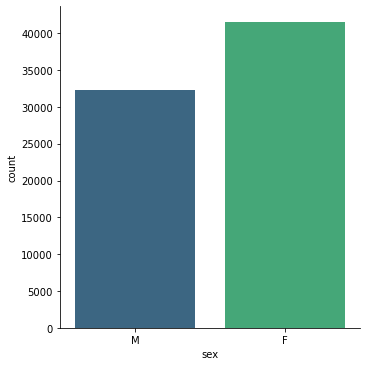

CAR
N(%%):	67.52395018902695
	 default rate(%%):	13.696018622571843
Y(%%):	32.47604981097305
	 default rate(%%):	10.627112279384153
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

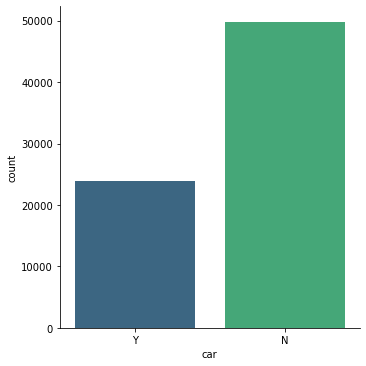

CAR_TYPE
N(%%):	81.01871299069093
	 default rate(%%):	13.625796524560553
Y(%%):	18.98128700930907
	 default rate(%%):	8.745002855511135
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

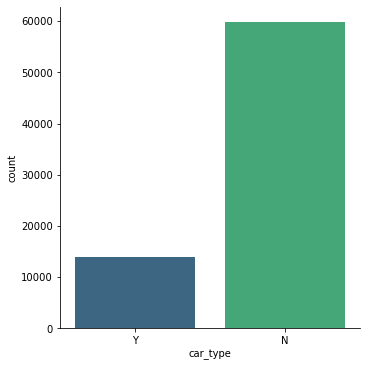

GOOD_WORK
0(%%):	83.5106166750227
	 default rate(%%):	13.340905403212721
1(%%):	16.489383324977304
	 default rate(%%):	9.450242419262059
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

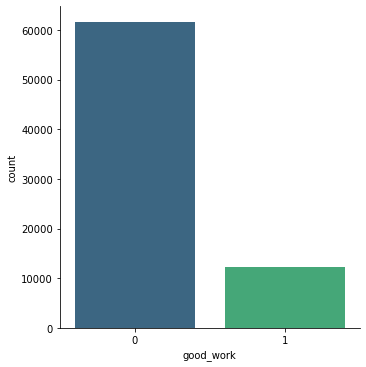

FOREIGN_PASSPORT
N(%%):	85.00521687285736
	 default rate(%%):	13.632378492978178
Y(%%):	14.994783127142645
	 default rate(%%):	7.410084944876197
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

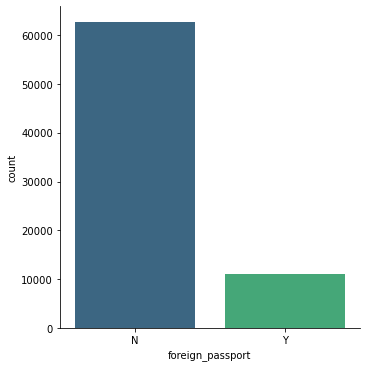

DEFAULT
0(%%):	87.3006409300939
	 default rate(%%):	0.0
1(%%):	12.699359069906096
	 default rate(%%):	100.0
Статистически значимые различия не найдены. Данные не несут ценности.


<Figure size 432x288 with 0 Axes>

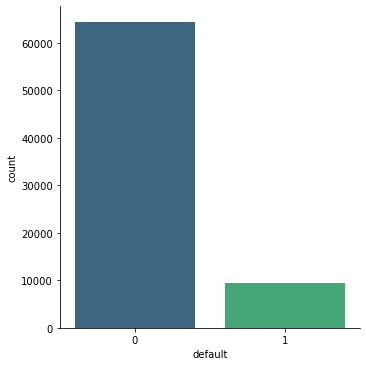

In [14]:
for column in bin_cols:
    summary(train, column)

In [15]:
print('Необходимо перекодировать: \t', obj_cols(train, bin_cols))

Необходимо перекодировать: 	 ['sex', 'car', 'car_type', 'foreign_passport']


### Вывод

За исключением пола, признаки распределены не равномерно. Тем не менее, пропорция меньшинства в этих случаях более 10%% и нет необходимости изменять выборку.

Все признаки несут ценность для модели, доли дефолтных клиентов в них довольно заметно отличаются.

Ряд признаков необходимо перекотировать в числовой формат для дальнейшего использования.

In [16]:
label_encoder = LabelEncoder()

In [17]:
# Кодировка бинарных столбцов
for column in obj_cols(train, bin_cols):
    train[column] = label_encoder.fit_transform(train[column])
    print(column.upper())
    print(dict(enumerate(label_encoder.classes_)))
    print()

SEX
{0: 'F', 1: 'M'}

CAR
{0: 'N', 1: 'Y'}

CAR_TYPE
{0: 'N', 1: 'Y'}

FOREIGN_PASSPORT
{0: 'N', 1: 'Y'}



In [18]:
#Результат кодировки
train[bin_cols].sample(5)

sex  car  car_type  good_work  foreign_passport  default
59205    1    0         0          0                 0        0
30635    0    0         0          0                 1        0
39561    0    0         0          0                 0        0
51001    0    0         0          0                 0        0
66616    1    0         0          0                 1        0

## Категориальные данные

EDUCATION
SCH(%%):	52.87650356501388
	 default rate(%%):	15.0591868244982
GRD(%%):	31.7925760627007
	 default rate(%%):	9.009201797560454
UGR(%%):	13.356555815598977
	 default rate(%%):	13.1519967400163
PGR(%%):	1.7103902465574485
	 default rate(%%):	6.443914081145586
ACD(%%):	0.26397431012899364
	 default rate(%%):	4.123711340206185
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

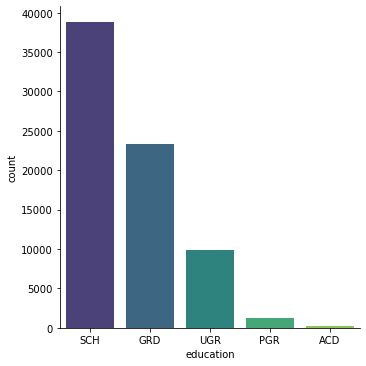

REGION_RATING
50(%%):	37.294543286494395
	 default rate(%%):	13.614068233840786
60(%%):	21.782137969349176
	 default rate(%%):	12.883359253499222
40(%%):	16.29696879361509
	 default rate(%%):	16.97015049472021
80(%%):	15.54086098727625
	 default rate(%%):	7.315371872002791
70(%%):	8.399842816298325
	 default rate(%%):	9.243426359090176
30(%%):	0.40650957330045123
	 default rate(%%):	19.0
20(%%):	0.27913657366630984
	 default rate(%%):	21.35922330097087
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

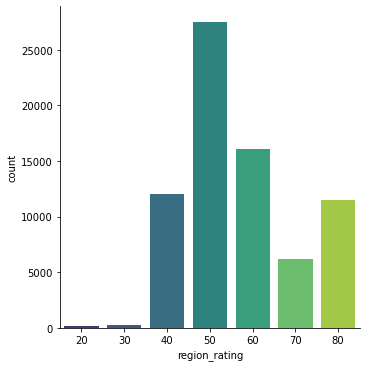

HOME_ADDRESS
2(%%):	54.1416550359761
	 default rate(%%):	15.514566022624887
1(%%):	44.15371481998401
	 default rate(%%):	9.289550406628818
3(%%):	1.704630144039892
	 default rate(%%):	11.605723370429253
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

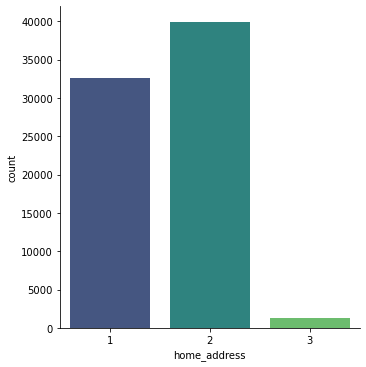

WORK_ADDRESS
3(%%):	60.920879686716624
	 default rate(%%):	14.795702751395718
2(%%):	27.786284366996846
	 default rate(%%):	10.250658343899346
1(%%):	11.292835946286536
	 default rate(%%):	7.415406767458603
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

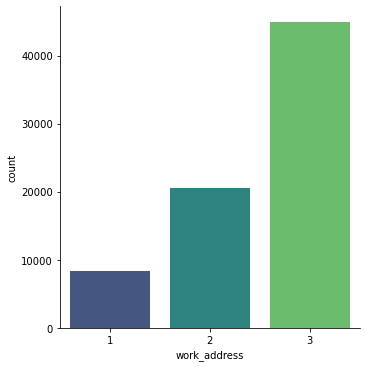

SNA
1(%%):	64.09436442228214
	 default rate(%%):	9.820088370224731
4(%%):	15.920269922356672
	 default rate(%%):	21.15073623287088
2(%%):	14.398569086301983
	 default rate(%%):	14.982119329945418
3(%%):	5.586796569059201
	 default rate(%%):	15.765219500363814
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

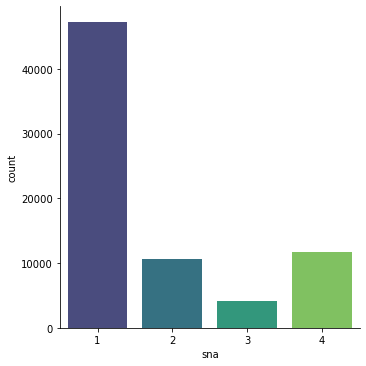

FIRST_TIME
3(%%):	42.35152237835201
	 default rate(%%):	12.026875699888018
4(%%):	25.389232916435184
	 default rate(%%):	8.203020761061003
1(%%):	16.58423555874741
	 default rate(%%):	18.612631750960045
2(%%):	15.6750091464654
	 default rate(%%):	15.542876901798063
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

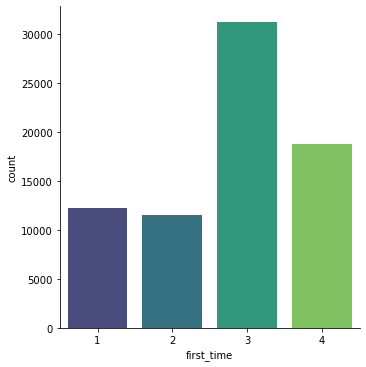

In [19]:
for column in cat_cols:
    summary(train, column)

In [20]:
print('Необходимо перекодировать: \t', obj_cols(train, cat_cols))

Необходимо перекодировать: 	 ['education']


In [21]:
print('EDUCATION')
print('default rate (средний): \t\t', train.default.mean()*100)
print('default rate (для пропущеных): \t', train[train.education.isna() == True].default.mean()*100)

EDUCATION
default rate (средний): 		 12.699359069906096
default rate (для пропущеных): 	 11.400651465798045


### Вывод

EDUCATION:

    Судя по значениям default rate для распределения, доля людей с категорией образования не отображает его уровень. Предпологаемая рассшифровка признака:

        SCH = school
        UGR = undergraduate
        GRD = graduate
        PGR = postgraduate
        ACD = advanced college degree
    
    Таким образом прризнак имеет смысл перекодировать в ручную. Что касается пропущенных значений, для них default rate ниже среднего по выборке. Что подтверждает то, что имеет смысл предсказать пропущенные значения, и мало вероятно, что они говорят об отсутствии образования. В дальнейшем для предсказания признака, необходимо сместить выборку для увеличения доли 'PGR' и'ACD'.

REGION_RATING:

    Признак имеет явную линейную зависимость с default rate. Так же, заметно, что ег распеределение условно нормально. Иммет смысл перенести его в числовые переменные.
    
Остальные признаки несут ценность для модели. Имееются низкие доли знвчений для признаков HOME_ADDRESS и SNA. Но, в этих случаях наблюдается отклонение default rate, и недооценка моделью этих значений может быть оправдана. 

In [22]:
# Перенос region_rating
cat_cols.remove('region_rating')
num_cols.append('region_rating')

In [23]:
# Кодировка education
mapping_dict = {'SCH': 1, 'UGR': 2, 'GRD':3, 'PGR':4, 'ACD':5}
train['education'] = train.education.map(mapping_dict)

In [24]:
#Результат кодировки
train[cat_cols].sample(5)

education  home_address  work_address  sna  first_time
30147        1.0             1             2    1           3
50395        3.0             1             2    1           4
58477        1.0             2             2    1           4
59694        1.0             2             3    2           2
42796        2.0             2             3    4           1

## Числовые данные

In [25]:
# Функция расчитывает кол-во выбросов по столбцам и их долю
def outbursts(df, col):
    Q25 = df[col].quantile(0.25)
    Q75 = df[col].quantile(0.75)
    IQR = Q75 - Q25
    lowest = Q25 - 1.5*IQR
    highest = Q75 + 1.5*IQR
    amount = df[(df[col] < lowest)|(df[col] > highest)].count()[0]
    ratio = amount/df.shape[0]
    return amount, ratio, lowest, highest

In [26]:
#Функция выводит основную информацию и график признака
def sum_up(df, col):
    print(col.upper())
    print(df[col].describe()[1:])
    print('Кол-во выбросов: {} \t (%%: {})'.format(outbursts(df, col)[0],outbursts(df, col)[1]*100))
    print()
    plt.figure()
    sns.displot(data=df, x=col, kde=True, palette = 'viridis')
    plt.show()
    plt.figure()
    sns.boxplot(data = df,  y = col, x = 'default', palette = 'viridis')
    plt.show()

AGE
mean    39.280641
std     11.520378
min     21.000000
25%     30.000000
50%     37.000000
75%     48.000000
max     72.000000
Name: age, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



<Figure size 432x288 with 0 Axes>

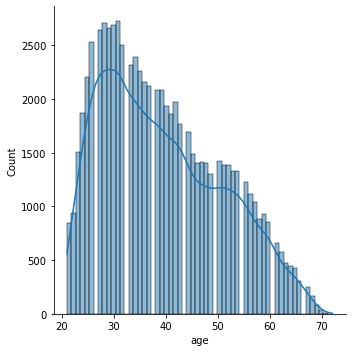

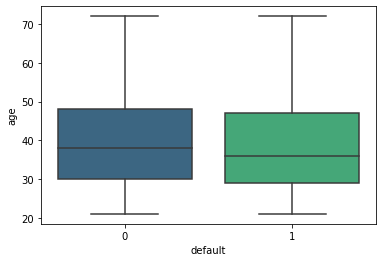

DECLINE_APP_CNT
mean     0.275749
std      0.804272
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     33.000000
Name: decline_app_cnt, dtype: float64
Кол-во выбросов: 12585 	 (%%: 17.05307659995393)



<Figure size 432x288 with 0 Axes>

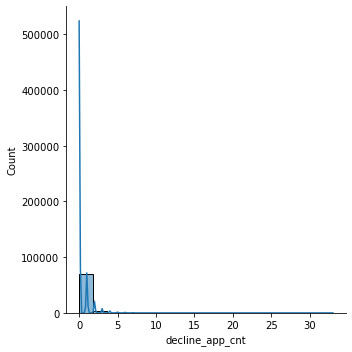

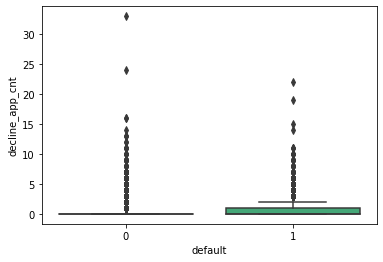

SCORE_BKI
mean   -1.904724
std     0.498231
min    -3.624586
25%    -2.259534
50%    -1.920823
75%    -1.569831
max     0.199773
Name: score_bki, dtype: float64
Кол-во выбросов: 351 	 (%%: 0.47561620076152794)



<Figure size 432x288 with 0 Axes>

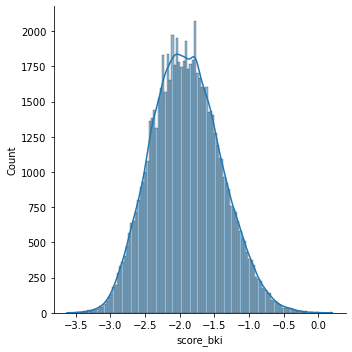

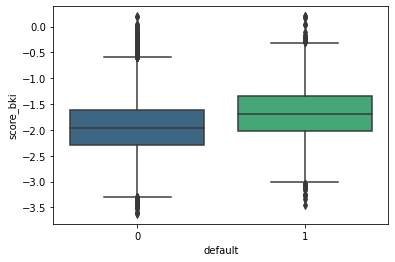

BKI_REQUEST_CNT
mean     2.000339
std      2.252073
min      0.000000
25%      0.000000
50%      1.000000
75%      3.000000
max     53.000000
Name: bki_request_cnt, dtype: float64
Кол-во выбросов: 1755 	 (%%: 2.3780810038076394)



<Figure size 432x288 with 0 Axes>

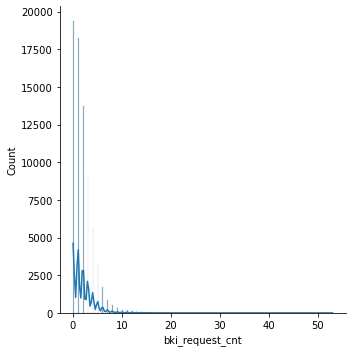

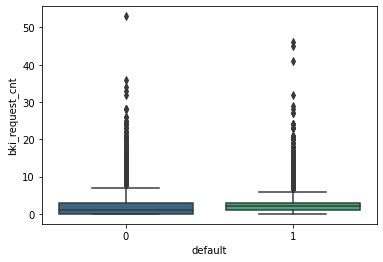

INCOME
mean      41099.775417
std       46166.322400
min        1000.000000
25%       20000.000000
50%       30000.000000
75%       48000.000000
max     1000000.000000
Name: income, dtype: float64
Кол-во выбросов: 4695 	 (%%: 6.361874822152061)



<Figure size 432x288 with 0 Axes>

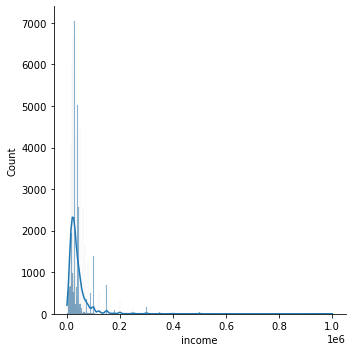

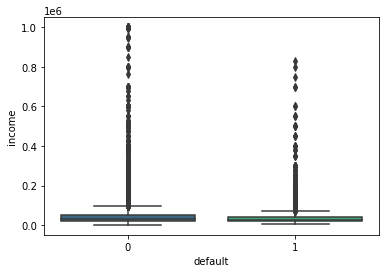

REGION_RATING
mean    56.725701
std     13.055717
min     20.000000
25%     50.000000
50%     50.000000
75%     60.000000
max     80.000000
Name: region_rating, dtype: float64
Кол-во выбросов: 11975 	 (%%: 16.22650713424301)



<Figure size 432x288 with 0 Axes>

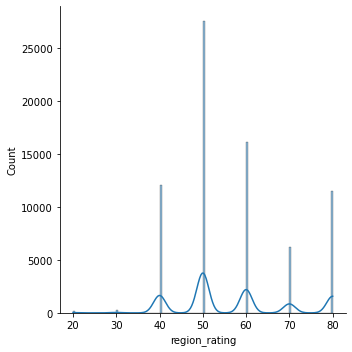

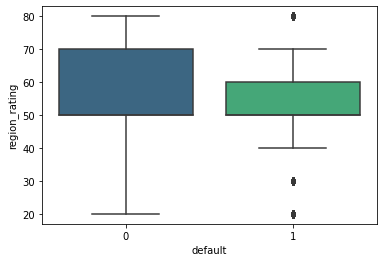

In [27]:
for col in num_cols:
    sum_up(train, col)

Из 6 числовых переменных: 2 - нормальныо распределены, 4 - логнормально. Следовательно, необходимо преобразовать столбцы: age, decline_app_cnt, bki_request_cnt, income. Вместе с тем, для первых двух минимальное значение равно 0. Так же, можно уменьшить размерность region_rating.

Имеются выбросы в данных.

In [28]:
# Предобработка столбцов, имеющих значение 0
for col in ['decline_app_cnt', 'bki_request_cnt']:
    train[col] = train[col].apply(lambda x: x+1)

In [29]:
# Нормализация
for col in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    train[col] = stats.boxcox(train[col])[0]

In [30]:
# Изменение размерности
train['region_rating'] = train['region_rating']/100

AGE
mean    3.240389
std     0.232844
min     2.769830
25%     3.060851
50%     3.228933
75%     3.434468
max     3.747995
Name: age, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



<Figure size 432x288 with 0 Axes>

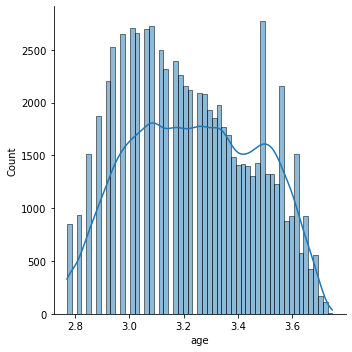

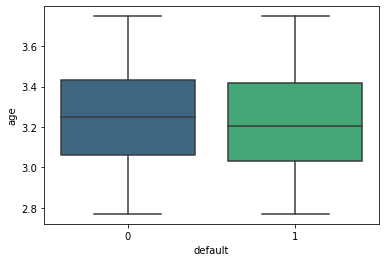

DECLINE_APP_CNT
mean    0.026804
std     0.059116
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     0.158546
Name: decline_app_cnt, dtype: float64
Кол-во выбросов: 12585 	 (%%: 17.05307659995393)



<Figure size 432x288 with 0 Axes>

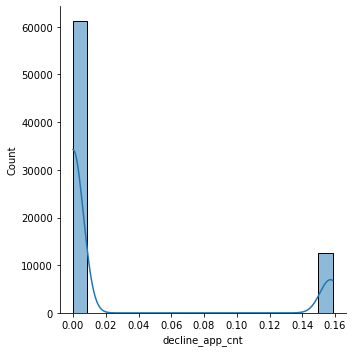

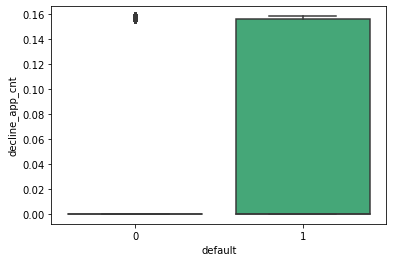

SCORE_BKI
mean   -1.904724
std     0.498231
min    -3.624586
25%    -2.259534
50%    -1.920823
75%    -1.569831
max     0.199773
Name: score_bki, dtype: float64
Кол-во выбросов: 351 	 (%%: 0.47561620076152794)



<Figure size 432x288 with 0 Axes>

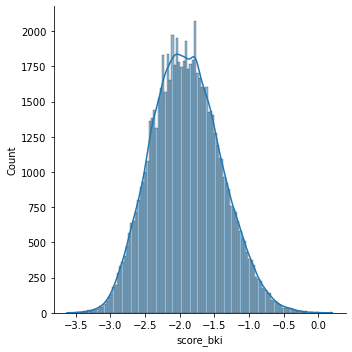

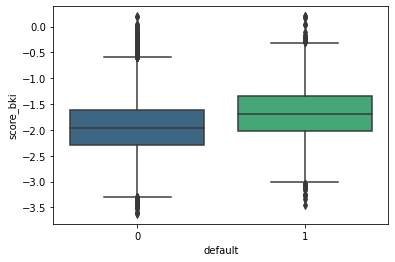

BKI_REQUEST_CNT
mean    0.807436
std     0.587435
min     0.000000
25%     0.000000
50%     0.663986
75%     1.272896
max     3.141523
Name: bki_request_cnt, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



<Figure size 432x288 with 0 Axes>

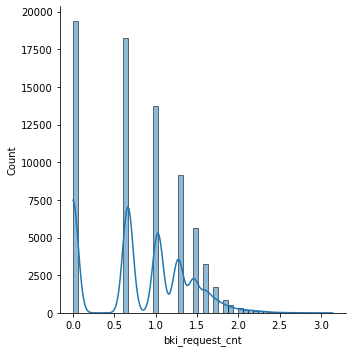

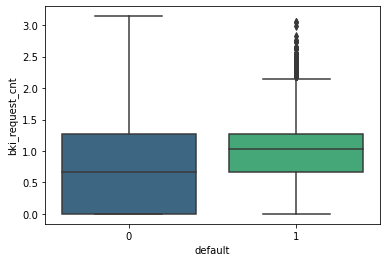

INCOME
mean    5.670380
std     0.179519
min     4.553056
25%     5.560409
50%     5.668952
75%     5.787797
max     6.402578
Name: income, dtype: float64
Кол-во выбросов: 1619 	 (%%: 2.193796663911435)



<Figure size 432x288 with 0 Axes>

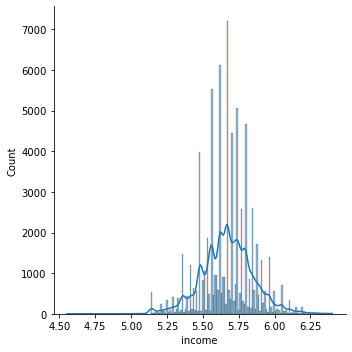

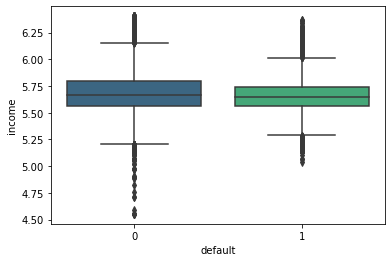

REGION_RATING
mean    0.567257
std     0.130557
min     0.200000
25%     0.500000
50%     0.500000
75%     0.600000
max     0.800000
Name: region_rating, dtype: float64
Кол-во выбросов: 11975 	 (%%: 16.22650713424301)



<Figure size 432x288 with 0 Axes>

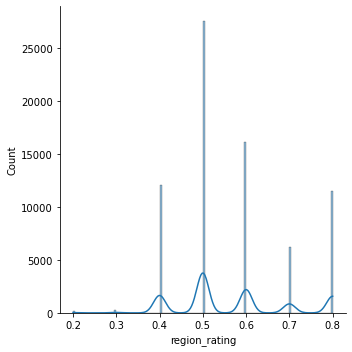

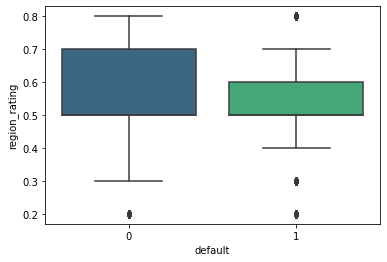

In [31]:
for col in num_cols:
    sum_up(train, col)

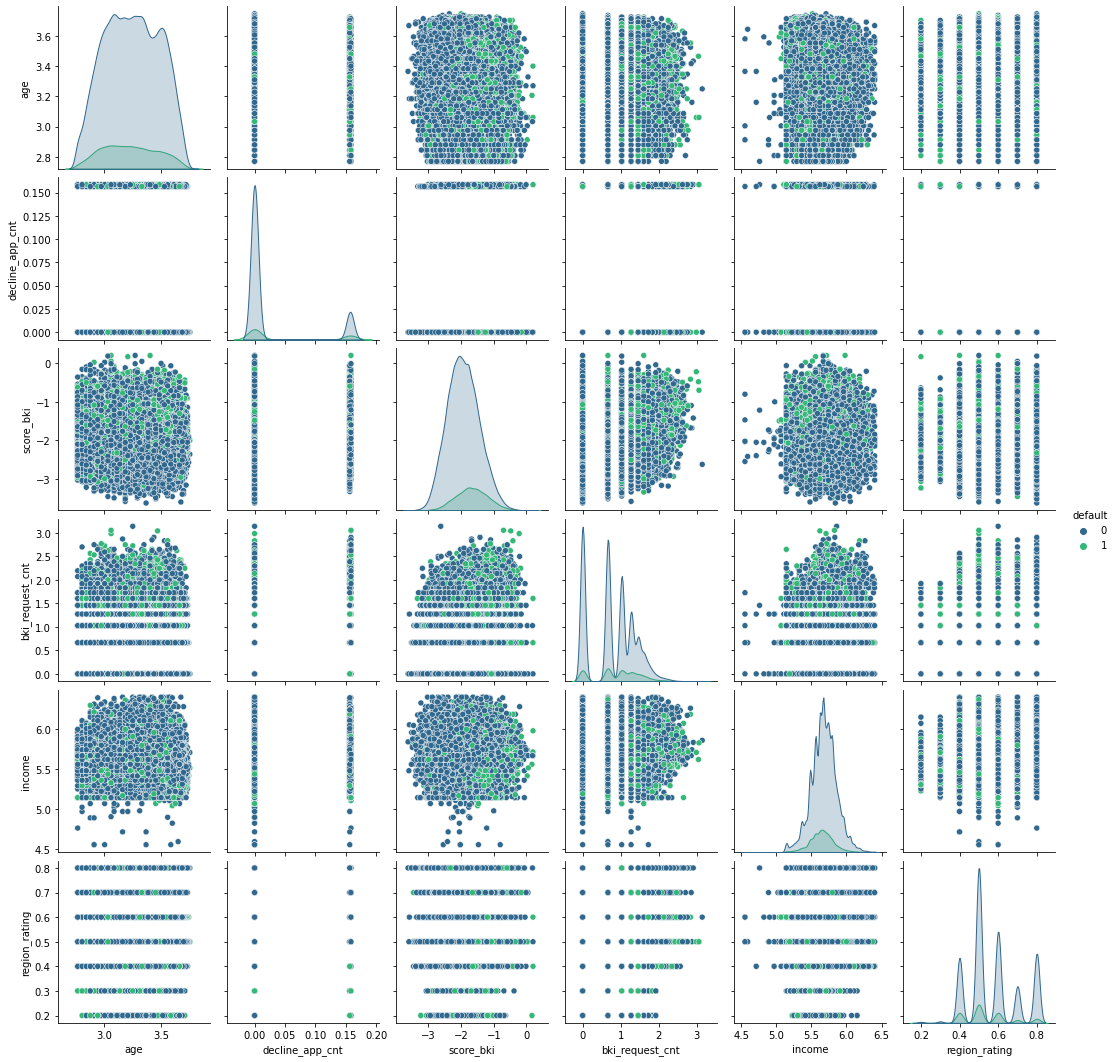

In [32]:
sns.pairplot(train[num_cols+['default']], hue = 'default', palette = 'viridis')

Обработка данных позволила привести к нормальному распределению параметры 'age' и 'income'. Так же, удалось снизить кол-во выбросов данных. В ходе тестирования выяснилось, что очистка от выбросов в 'score_bki' и 'income' снижает ROC AUC, как на тестовой, так и на валидационной выборках. 'decline_app_cnt' после нормализации имеет два ярко выраженных пика, что позволяет перекодировать признак в бинарный.

DECLINE_APP_CNT
0(%%):	82.94692340004607
	 default rate(%%):	10.95337667853759
1(%%):	17.05307659995393
	 default rate(%%):	21.191895113230036
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

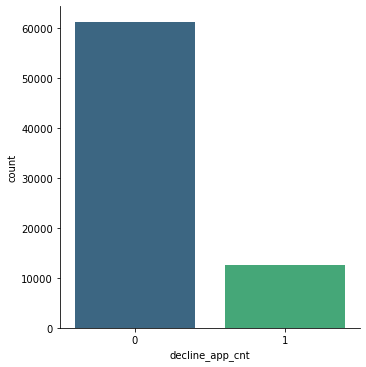

In [33]:
# Перекодировка decline_app_cnt
train['decline_app_cnt'] = train.decline_app_cnt.apply(lambda x: 1 if x>0 else 0)
summary(train, 'decline_app_cnt')

In [34]:
# Перенос decline_app_cnt
num_cols.remove('decline_app_cnt')
bin_cols.append('decline_app_cnt')

<AxesSubplot:>

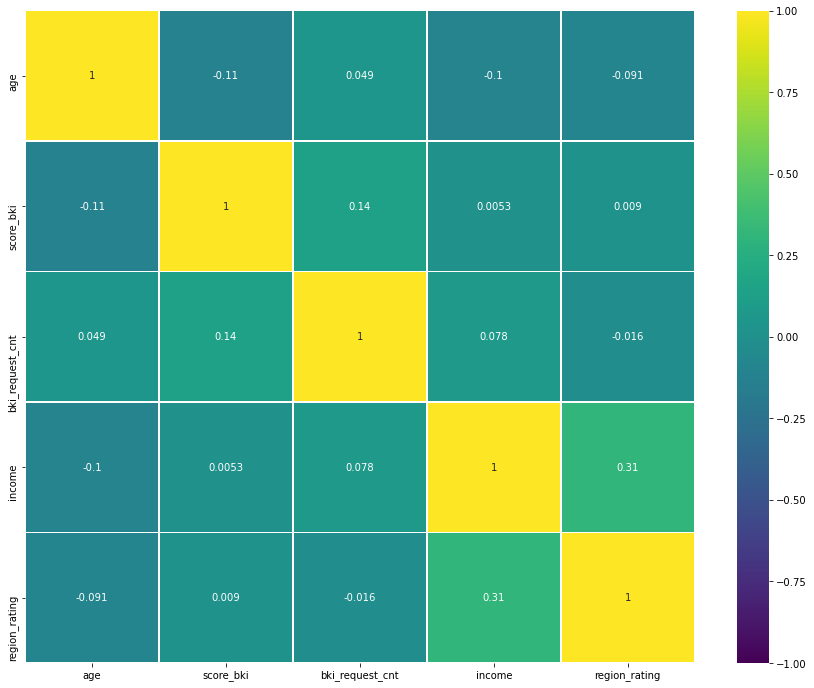

In [35]:
# Корреляционная матрица
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(train[num_cols].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

### Вывод

За исключением 'bki_request_cnt', числовые данные приведены к нормальному распределнию. В данных сохраняются выбросы.

Построенние коррелиционной матрицы не выявило высоких значений, которые могли бы препядствовать работе модели.

## Время/дата

In [36]:
train['app_year'] = train.app_date.dt.year
train['app_month'] = train.app_date.dt.month
train['app_day'] = train.app_date.dt.day
train['app_week_day'] = train.app_date.dt.dayofweek
train['timestamp'] = train.app_date.values.astype(np.int64) // 10 ** 9

APP_YEAR
2014(%%):	100.0
	 default rate(%%):	12.699359069906096
Статистически значимые различия не найдены. Данные не несут ценности.


<Figure size 432x288 with 0 Axes>

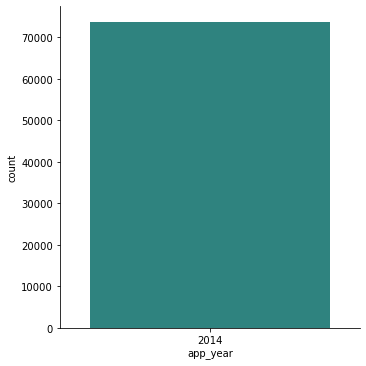

APP_MONTH
3(%%):	28.696865811189852
	 default rate(%%):	12.753801114363963
2(%%):	24.428515291535117
	 default rate(%%):	13.262702462835588
4(%%):	23.961029282239597
	 default rate(%%):	10.59209410167958
1(%%):	22.913589615035434
	 default rate(%%):	14.23418095801301
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

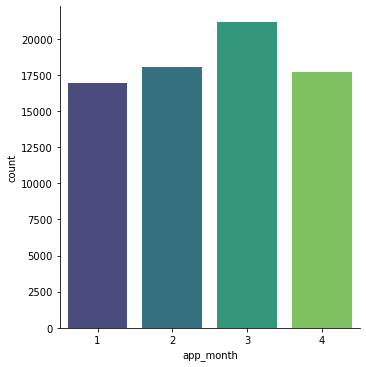

APP_DAY
17(%%):	4.09897153077955
	 default rate(%%):	12.462809917355372
28(%%):	3.9959891055434356
	 default rate(%%):	13.021363173957273
18(%%):	3.907912031328338
	 default rate(%%):	11.58113730929265
21(%%):	3.8862315207523137
	 default rate(%%):	11.157601115760112
11(%%):	3.726337755254136
	 default rate(%%):	11.672727272727272
24(%%):	3.6951720213011017
	 default rate(%%):	11.367803447011369
15(%%):	3.569154053577962
	 default rate(%%):	11.996962794229308
14(%%):	3.5298581281589176
	 default rate(%%):	12.936660268714013
10(%%):	3.5014024580278864
	 default rate(%%):	11.455108359133128
27(%%):	3.4946272984728792
	 default rate(%%):	12.563008918185343
4(%%):	3.464816596430846
	 default rate(%%):	13.648807195932733
20(%%):	3.4336508624778115
	 default rate(%%):	13.614838200473558
3(%%):	3.426875702922804
	 default rate(%%):	13.641755634638198
22(%%):	3.3862247455927585
	 default rate(%%):	12.364945978391356
7(%%):	3.346928820173715
	 default rate(%%):	13.157894736842104
19(%%):	3.3184

<Figure size 432x288 with 0 Axes>

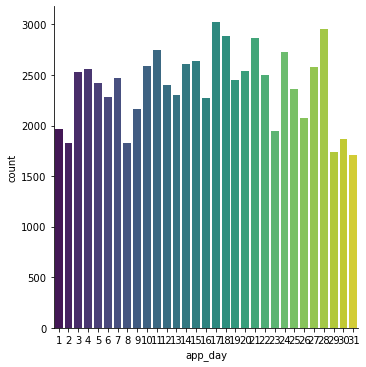

APP_WEEK_DAY
1(%%):	16.498868548354313
	 default rate(%%):	12.738173455978973
0(%%):	16.292903697882085
	 default rate(%%):	12.70791749833666
2(%%):	15.908074635157657
	 default rate(%%):	12.427597955706984
3(%%):	15.73869564628247
	 default rate(%%):	13.198450279810588
4(%%):	15.26172441360994
	 default rate(%%):	11.99502796768179
5(%%):	11.153267659453379
	 default rate(%%):	13.096829060867451
6(%%):	9.146465399260153
	 default rate(%%):	12.918518518518518
Статистически значимые различия не найдены. Данные не несут ценности.


<Figure size 432x288 with 0 Axes>

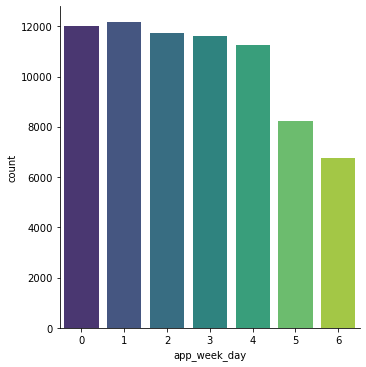

In [37]:
for category in ['app_year', 'app_month', 'app_day', 'app_week_day']:
    summary(train, category)

TIMESTAMP
mean    1.393808e+09
std     2.775331e+06
min     1.388534e+09
25%     1.391386e+09
50%     1.393891e+09
75%     1.396224e+09
max     1.398816e+09
Name: timestamp, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



<Figure size 432x288 with 0 Axes>

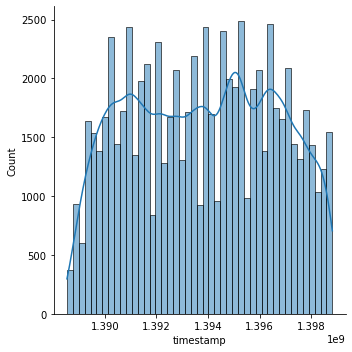

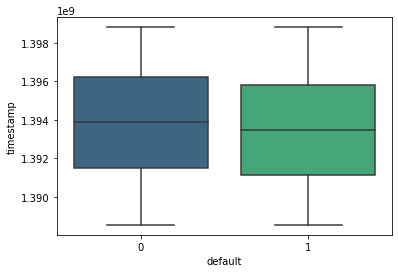

In [38]:
sum_up(train, 'timestamp')

In [39]:
num_cols.append('timestamp')

### Вывод

Данные предоставлены за 4 месяца 2014 года. Найдены статистически значимые различия между месяцами, и числами месяца. Default rate для месяцев снижается. Аналогично 'timestamp' ниже для дефолтных клиентов. Не ясно, является ли эта закономерность отображение объективного тренда. В любом случае, иммет смысл сохранить данные. Насколько данные переменные полезны для модели будет проанализировано позже.

Столбец 'app_month' иммет 4 уникальных значения и может рассмотриваться как категориальный признак.

Напротив, 'app_day' имеет 31 уникальное значение. В этом случае, создание dummy-переменных будет слишком громоздким. Значения можно заменить на средний default rate для каждого и обрабатывать признак как числовой.

Столбцы 'app_year' и 'app_week_day' будут удалены, т.к. не несут ценности.

In [40]:
cat_cols.append('app_month')

In [41]:
train['app_day'] = train.groupby('app_day')['default'].transform('mean')
num_cols.append('app_day')

In [42]:
train.drop(['app_date', 'app_year', 'app_week_day'], axis = 1, inplace = True)

## Итоговый DataFrame

In [43]:
train.sample(5)

education  sex       age  car  car_type  decline_app_cnt  good_work  \
72073        1.0    1  2.944877    0         0                0          0   
42042        1.0    1  3.137514    1         1                0          0   
49848        2.0    0  3.581799    0         0                0          1   
64482        3.0    0  3.383819    1         1                0          0   
67098        3.0    0  3.087277    1         1                0          0   

       score_bki  bki_request_cnt  region_rating  home_address  work_address  \
72073  -2.495522         0.663986            0.4             2             3   
42042  -1.718093         0.663986            0.7             1             1   
49848  -1.296926         0.000000            0.8             2             3   
64482  -1.611682         0.000000            0.8             2             3   
67098  -1.190299         1.921474            0.8             2             3   

         income  sna  first_time  foreign_passport  default  app_month  \
72073  5.479840    1           4                 0        0          4   
42042  5.668952    2           4                 1        0          3   
49848  5.782627    1           1                 0        1          3   
64482  5.894097    1           3                 0        0          3   
67098  5.771906    1           3                 0        0          1   

        app_day   timestamp  
72073  0.114551  1397088000  
42042  0.116727  1394496000  
49848  0.113456  1394928000  
64482  0.119970  1394841600  
67098  0.123649  1390348800

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   education         73492 non-null  float64
 1   sex               73799 non-null  int64  
 2   age               73799 non-null  float64
 3   car               73799 non-null  int64  
 4   car_type          73799 non-null  int64  
 5   decline_app_cnt   73799 non-null  int64  
 6   good_work         73799 non-null  int64  
 7   score_bki         73799 non-null  float64
 8   bki_request_cnt   73799 non-null  float64
 9   region_rating     73799 non-null  float64
 10  home_address      73799 non-null  int64  
 11  work_address      73799 non-null  int64  
 12  income            73799 non-null  float64
 13  sna               73799 non-null  int64  
 14  first_time        73799 non-null  int64  
 15  foreign_passport  73799 non-null  int64  
 16  default           73799 non-null  int64 

# Заполнение пропусков 'education'

EDUCATION
1.0(%%):	52.87650356501388
	 default rate(%%):	15.0591868244982
3.0(%%):	31.7925760627007
	 default rate(%%):	9.009201797560454
2.0(%%):	13.356555815598977
	 default rate(%%):	13.1519967400163
4.0(%%):	1.7103902465574485
	 default rate(%%):	6.443914081145586
5.0(%%):	0.26397431012899364
	 default rate(%%):	4.123711340206185
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

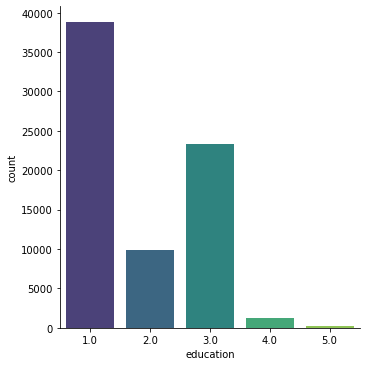

In [45]:
summary(train, 'education')

## Undersampling

Так как, в данных доля 4го и 5го классов (PGR и ACD) крайне мала, необходимо устранить диссбаланс выборки.

Метод undersampling выбран в целях быстродействия (переменная не является целевой и пропусков в ней не очень много).

In [46]:
# Функция возвращает сбаласированную выборку, сохраняя пропорции среди преобладающих значений
def undersampling(df, col, min_frac = 0.1):
    vc = df[col].dropna().value_counts(ascending=True)
    min_value = vc.min()
    to_distribute = min_value/min_frac*(1-len(vc)*min_frac)
    parts = []
    count = 0
    for i in vc.index:
        if vc[i]/vc[i:].sum() < min_frac:
            parts.append(df[df[col] == i].copy().head(min_value))
            count += 1
        else:
            add_value = vc[i]/vc.iloc[count:].sum()*to_distribute
            parts.append(df[df[col] == i].copy().head(min_value+int(add_value)))
    sample = pd.concat(parts)
    return sample

education  sex       age  car  car_type  decline_app_cnt  good_work  \
328         3.0    0  3.087277    0         0                0          0   
1575        2.0    1  3.250147    1         0                0          0   
230         1.0    1  3.270776    0         0                0          0   
484         1.0    1  3.270776    1         0                0          0   
135         1.0    0  3.466398    1         1                0          1   

      score_bki  bki_request_cnt  region_rating  home_address  work_address  \
328   -1.786417         1.457966            0.5             3             3   
1575  -2.263073         1.457966            0.6             1             2   
230   -1.891840         0.663986            0.5             1             1   
484   -1.982726         0.000000            0.7             2             3   
135   -2.434735         1.457966            0.4             2             3   

        income  sna  first_time  foreign_passport  default  app_month  \
328   5.820880    3           1                 0        0          2   
1575  5.620854    2           3                 0        0          1   
230   5.841720    2           3                 0        0          1   
484   5.797779    1           3                 1        0          2   
135   5.722883    1           3                 0        0          4   

       app_day   timestamp  
328   0.111576  1392940800  
1575  0.119970  1389744000  
230   0.111576  1390262400  
484   0.113456  1392508800  
135   0.115811  1397779200

EDUCATION
1.0(%%):	36.9778236204229
	 default rate(%%):	14.504881450488144
3.0(%%):	26.19907168643631
	 default rate(%%):	8.46456692913386
2.0(%%):	16.812790097988653
	 default rate(%%):	10.429447852760736
5.0(%%):	10.00515729757607
	 default rate(%%):	4.123711340206185
4.0(%%):	10.00515729757607
	 default rate(%%):	7.731958762886598
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

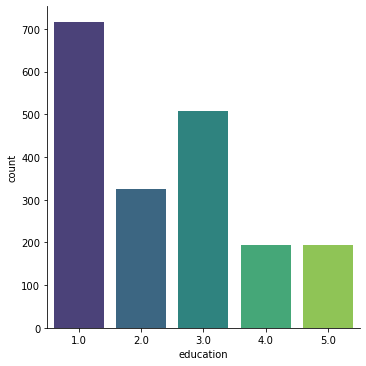

In [47]:
# Применение функции, отображение итога
edu_sample = undersampling(train, 'education')
display(edu_sample.sample(5))
summary(edu_sample, 'education')

## Feature selection

In [48]:
# Функция измеряет взаимную информацию для ряда переменных
def mi_class(features, target):
    mi_scores = mutual_info_classif(features, target, random_state = 100)
    mi_scores = pd.Series(mi_scores, index=features.columns)
    return mi_scores

<AxesSubplot:>

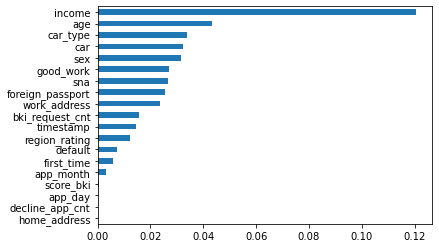

In [49]:
# Расчет взаимной иформации
features = edu_sample.copy().drop('education', axis = 1)
target = edu_sample.education
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

In [50]:
# Фунция возвращает параметры из списка, для который MI score выше определенного значения
def mi_test(cols, value = 0.01):
    useful_cols = []
    for col in cols:
        if mi_scores[col]>value:
            useful_cols.append(col)
    return useful_cols

In [51]:
# Создание списков переменных, которые ценны для предсказания education
edu_bin_cols = mi_test(bin_cols, 0.01)
edu_num_cols = mi_test(num_cols, 0.01)
edu_cat_cols = mi_test(cat_cols[1:], 0.01)

## Классификаторы

In [52]:
# Создание предобработки признаков (dummy-переменные, стандартизация)
edu_OHE = OneHotEncoder(sparse = False)
edu_OHE.fit(edu_sample[edu_cat_cols].values)
edu_SS = StandardScaler()
edu_SS.fit(edu_sample[edu_num_cols].values)

StandardScaler()

In [53]:
# Применеие предобработки
W_cat = edu_OHE.transform(edu_sample[edu_cat_cols].values)
W_num = edu_SS.transform(edu_sample[edu_num_cols].values)
W = np.hstack([W_num, edu_sample[edu_bin_cols].values, W_cat])
z = edu_sample.education.values

In [54]:
# Разбиение выборки
W_train, W_add, z_train, z_add = train_test_split(W, z, test_size=0.15, random_state=5)
W_test, W_valid, z_test, z_valid = train_test_split(W_add, z_add, test_size=0.5, random_state=5)

In [55]:
# Список тестируемых моделей
edu_m1 = LogisticRegression(max_iter=1500)
edu_m2 = KNeighborsClassifier(n_neighbors=50)
edu_m3 = DecisionTreeClassifier(random_state=50, max_depth=50)
edu_models = [edu_m1, edu_m2, edu_m3]

Benchmark (random): 		 0.1683800676972508
Benchmark (most common): 	 0.22514656386213844

LogisticRegression(max_iter=1500)
F1 score: 		 0.41102338554671214
Confusion matrix:


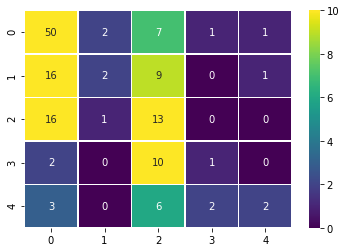

KNeighborsClassifier(n_neighbors=50)
F1 score: 		 0.3571575272965371
Confusion matrix:


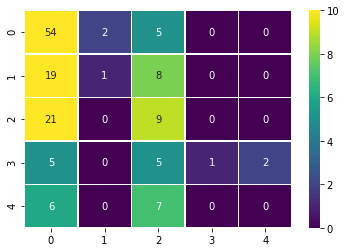

DecisionTreeClassifier(max_depth=50, random_state=50)
F1 score: 		 0.3273560520770064
Confusion matrix:


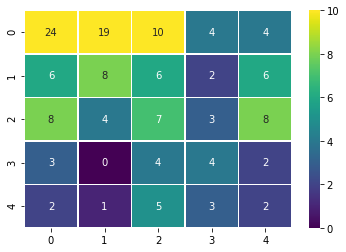

In [56]:
# Оценка результатов моделей
print('Benchmark (random): \t\t', f1_score(z_test, 
                                           np.random.randint(1, 6, len(z_test)), average='weighted'))
print('Benchmark (most common): \t', f1_score(z_test, 
                                              [train.education.value_counts().index[0]]* 
                                              np.random.randint(1, 6, len(z_test)), average='weighted'))
print()

for model in edu_models:
    model.fit(W_train, z_train)
    print(model)
    print('F1 score: \t\t', f1_score(
        z_test, model.predict(W_test), average='weighted'))
    print('Confusion matrix:')
    plt.figure()
    sns.heatmap(confusion_matrix(z_test, model.predict(W_test)),
                vmin=0, vmax=10, annot=True, linewidths=.5, cmap='viridis')
    plt.show()

Модели не обладают высокой точностью предсказания. Тем не менее, их результат выше, чем заполние переменной случайной величиной или самым частовстречающимся значением (в данном случае F1 score для последнего занижен из-за смещения выборки).

### Сравнение моделей в зависимости от вариации  основных гиперпараметров:

In [57]:
# Измерение точности логистической регресии в зависимости от кол-ва итераций
start_time = time.time()
m1_test = []
for n_iter in range(1, 51, 1):
    model = LogisticRegression(max_iter=n_iter)
    model.fit(W_train, z_train)
    m1_test.append(f1_score(z_test, model.predict(W_test), average ='weighted'))
print('Веремя выполнения кода: \t{} sec.'.format((time.time() - start_time)))

Веремя выполнения кода: 	0.9965400695800781 sec.


In [58]:
# Измерение точности метода близлежащих соседей в зависимости от кол-ва соседей
start_time = time.time()
m2_test = []
for depth in range(1, 51, 1):
    model = KNeighborsClassifier(n_neighbors=depth) 
    model.fit(W_train, z_train)
    m2_test.append(f1_score(z_test, model.predict(W_test), average='weighted'))
print('Веремя выполнения кода: \t{} sec.'.format((time.time() - start_time)))

Веремя выполнения кода: 	0.48633718490600586 sec.


In [59]:
# Измерение точности дерева решений в зависимости от глубины
start_time = time.time()
m3_test = []
for depth in range(1, 51, 1):
    model = DecisionTreeClassifier(random_state=50, max_depth=depth)
    model.fit(W_train, z_train)
    m3_test.append(f1_score(z_test, model.predict(W_test), average='weighted'))
print('Веремя выполнения кода: \t{} sec.'.format((time.time() - start_time)))

Веремя выполнения кода: 	0.39579010009765625 sec.


In [60]:
results = [m1_test, m2_test, m3_test]

LogisticRegression(max_iter=1500)
Лучший результат (F1 = 0.4439122357406913) при параметре = Int64Index([6], dtype='int64')

KNeighborsClassifier(n_neighbors=50)
Лучший результат (F1 = 0.40585754605753327) при параметре = Int64Index([6], dtype='int64')

DecisionTreeClassifier(max_depth=50, random_state=50)
Лучший результат (F1 = 0.44308930633794513) при параметре = Int64Index([6], dtype='int64')



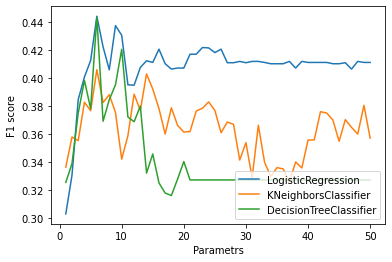

In [61]:
# Визуализация результатов
count = 0
for result in results:
    r = pd.Series(result, index = [x for x in range(1, 51, 1)])
    print(edu_models[count])
    print('Лучший результат (F1 = {}) при параметре = {}'.format(r.max(), r[r == r.max()].index))
    print()
    count+=1
    
ax = sns.lineplot(x=range(1, 51, 1), y=results[0], label='LogisticRegression')
ax = sns.lineplot(x=range(1, 51, 1), y=results[1], label='KNeighborsClassifier')
ax = sns.lineplot(x=range(1, 51, 1), y=results[2], label='DecisionTreeClassifier')
ax.set(ylabel='F1 score', xlabel='Parametrs')
plt.legend(loc='lower right')
plt.show()

### Вывод

LogisticRegression показывает наилучший результат с наименьшим разбросом. Т.к. модель выходит на плато при 20ти итерациях, для заполнения пропусков будет использована LogisticRegression(max_iter=20).

## Применение модели

In [62]:
# Выбираем данные с пропущенным 'education'
edu_na_sample = train[train.education.isna() == True].drop('education', axis = 1)

In [63]:
# Предобработка признаков
W_na_cat = edu_OHE.transform(edu_na_sample[edu_cat_cols].values)
W_na_num = edu_SS.transform(edu_na_sample[edu_num_cols].values)
W_na = np.hstack([W_na_num, edu_na_sample[edu_bin_cols].values, W_na_cat])

In [64]:
# Применение модели
edu_model = LogisticRegression(max_iter=20)
edu_model.fit(W, z)
edu_predictions = pd.Series(edu_model.predict(W_na), index = train[train.education.isna() == True].index)

In [65]:
# Функция возвращает 1, если ячейка в формате 'int' пуста
def isna(cell):
    if cell%1 != 0:
        return 1
    else:
        return 0 

In [66]:
# Создание признака, отмечающего пропуск в образовании
train['edu_isna'] = train.education.apply(isna)

In [67]:
# Функция возвращает предсказание для пропущенного значения
def filling(row):
    if row['edu_isna'] == 1:
        return edu_predictions[row.name]
    else:
        return row['education']

In [68]:
# Заполнение пропусков
train['education'] = train.apply(filling, axis = 1)

## Результаты

In [69]:
train[train.edu_isna == 1].sample(5)

education  sex       age  car  car_type  decline_app_cnt  good_work  \
5167         1.0    0  3.496999    0         0                1          0   
38901        3.0    1  3.161431    0         0                0          0   
54753        1.0    1  3.250147    0         0                0          0   
45643        1.0    0  3.434468    0         0                0          0   
28655        1.0    0  3.060851    1         0                0          0   

       score_bki  bki_request_cnt  region_rating  ...  work_address    income  \
5167   -1.942427         2.297558            0.8  ...             3  5.771906   
38901  -1.372291         0.000000            0.8  ...             3  5.878065   
54753  -1.049878         0.663986            0.8  ...             3  5.742558   
45643  -1.896040         1.272896            0.5  ...             2  5.620854   
28655  -2.171383         1.605396            0.5  ...             1  5.668952   

       sna  first_time  foreign_passport  default  app_month   app_day  \
5167     1           4                 0        0          4  0.140947   
38901    1           3                 0        0          3  0.136148   
54753    4           1                 0        0          3  0.136418   
45643    1           3                 0        0          1  0.123649   
28655    1           4                 1        0          1  0.119970   

        timestamp  edu_isna  
5167   1398211200         1  
38901  1395273600         1  
54753  1393804800         1  
45643  1390348800         1  
28655  1389744000         1  

[5 rows x 21 columns]

EDUCATION
1.0(%%):	52.87650356501388
	 default rate(%%):	15.0591868244982
3.0(%%):	31.7925760627007
	 default rate(%%):	9.009201797560454
2.0(%%):	13.356555815598977
	 default rate(%%):	13.1519967400163
4.0(%%):	1.7103902465574485
	 default rate(%%):	6.443914081145586
5.0(%%):	0.26397431012899364
	 default rate(%%):	4.123711340206185
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

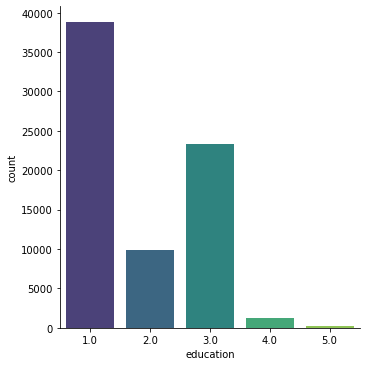

EDUCATION
1.0(%%):	62.54071661237784
	 default rate(%%):	13.541666666666666
3.0(%%):	22.475570032573287
	 default rate(%%):	8.695652173913043
2.0(%%):	7.166123778501629
	 default rate(%%):	13.636363636363635
5.0(%%):	5.863192182410423
	 default rate(%%):	0.0
4.0(%%):	1.9543973941368076
	 default rate(%%):	0.0
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

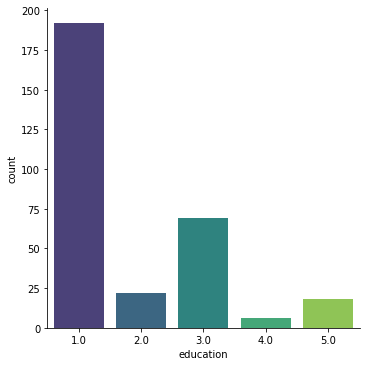

In [70]:
summary(train[train.edu_isna == 0], 'education')
summary(train[train.edu_isna == 1], 'education')

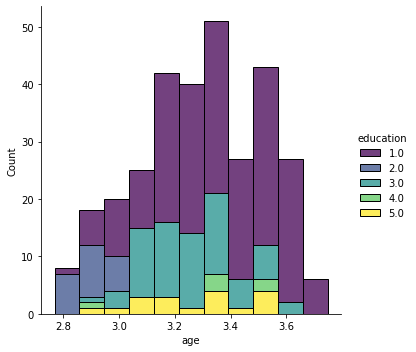

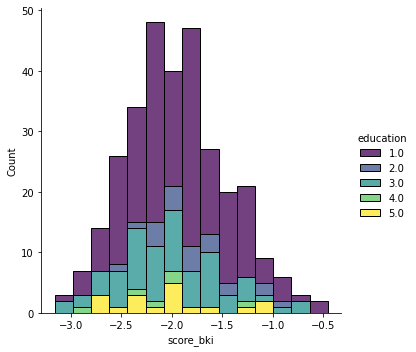

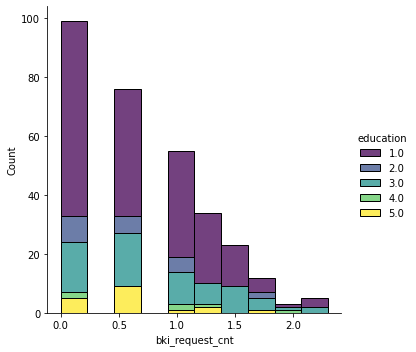

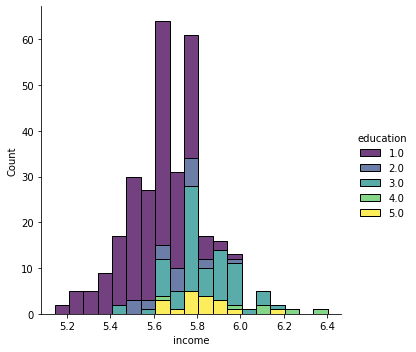

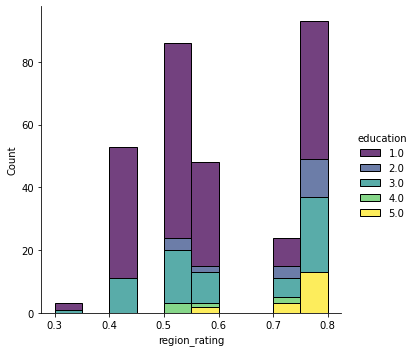

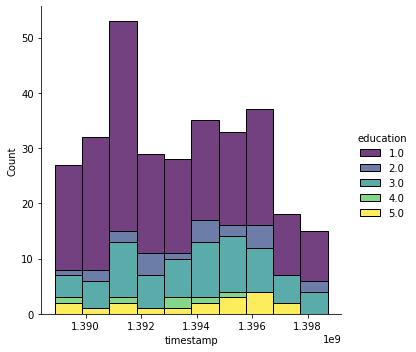

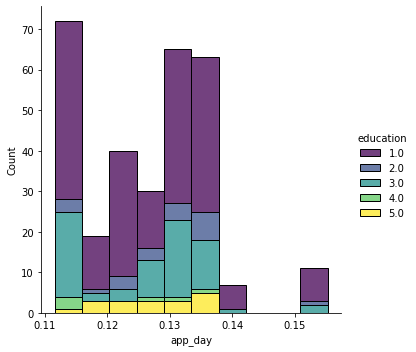

In [71]:
for col in num_cols:
    sns.displot(train[train.edu_isna == 1], x=col, hue='education', palette = 'viridis', multiple='stack')

## Вывод

Распределение предсказанных значений схожи со средними по популяции. Имеются трудности с предсказанием 2го класса (UGR), вероятно, из-за того, что 1ый и 3ий классы в выборке представлены большим кол-вом значений. 

Вместе с тем, зависимости для предсказанных значений выглядят логичными. Так, образование выше в регионах с высоким рейтингом, для людей с более высоким доходом. Неоконченное высшее предсказано для более молодых людей.

В целом, иммет смысл оставить вспомогательную переменную 'edu_isna', чтобы была возможности разделить предсказанные и объективные значения переменной.

# Feature Engineering

<AxesSubplot:>

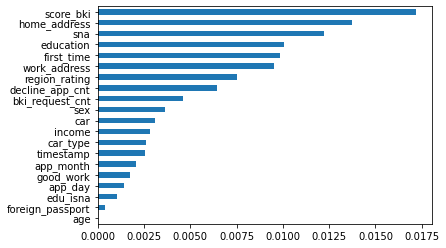

In [72]:
# Расчет взаимной иформации
features = train.copy().drop('default', axis = 1)
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

In [73]:
features.columns

Index(['education', 'sex', 'age', 'car', 'car_type', 'decline_app_cnt',
       'good_work', 'score_bki', 'bki_request_cnt', 'region_rating',
       'home_address', 'work_address', 'income', 'sna', 'first_time',
       'foreign_passport', 'app_month', 'app_day', 'timestamp', 'edu_isna'],
      dtype='object')

Параметр 'app_day' не представляет ценности для построения модели.

In [74]:
# Удаление 'app day'
train.drop('app_day', axis = 1, inplace = True)
num_cols.remove('app_day')

## Clusters

Unsupervised ML способен разбить данные на кластеры, для которых закономерности отличаются.

Параметры выбраны произвольно.

In [75]:
# Отбираем признаки с MI score > 0.005
cluster_cols = mi_test(features.columns, 0.005)
cluster_cols

['education',
 'decline_app_cnt',
 'score_bki',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time']

In [76]:
# Применение кластеризации
kmeans = KMeans(n_clusters=5, max_iter = 1500, n_init = 20, random_state = 100)
kmeans.fit(train[cluster_cols])
train["cluster"] = kmeans.predict(train[cluster_cols])

### Результаты

In [77]:
train.sample(5)

education  sex       age  car  car_type  decline_app_cnt  good_work  \
39997        1.0    1  3.270776    1         1                1          0   
4733         3.0    1  2.844680    0         0                0          0   
48382        1.0    1  2.975565    0         0                0          0   
59843        1.0    1  3.329446    1         1                0          0   
49779        1.0    1  2.944877    0         0                0          0   

       score_bki  bki_request_cnt  region_rating  ...  work_address    income  \
39997  -1.484116         0.000000            0.7  ...             3  5.894097   
4733   -1.519499         0.663986            0.3  ...             1  5.797779   
48382  -2.259557         1.272896            0.6  ...             3  5.620854   
59843  -1.755749         0.000000            0.8  ...             3  5.797779   
49779  -1.550219         1.272896            0.6  ...             2  5.620854   

       sna  first_time  foreign_passport  default  app_month   timestamp  \
39997    1           3                 0        0          3  1394841600   
4733     4           3                 0        0          4  1397001600   
48382    4           1                 0        0          4  1397433600   
59843    1           4                 1        0          2  1391644800   
49779    2           3                 1        0          2  1391558400   

       edu_isna  cluster  
39997         0        3  
4733          0        2  
48382         0        2  
59843         0        3  
49779         0        4  

[5 rows x 21 columns]

CLUSTER
1(%%):	27.82287022859388
	 default rate(%%):	7.427068621243851
3(%%):	22.17916231927262
	 default rate(%%):	12.701612903225806
2(%%):	20.10867355926232
	 default rate(%%):	20.350404312668463
4(%%):	17.023265897911894
	 default rate(%%):	9.185704051580036
0(%%):	12.86602799495928
	 default rate(%%):	16.787783043707215
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

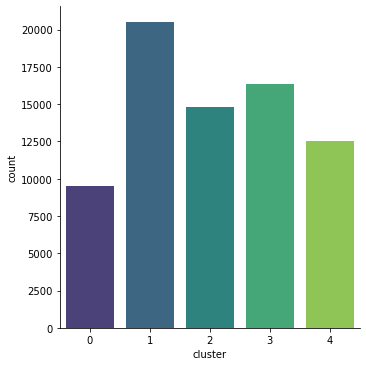

In [78]:
summary(train, 'cluster')

Имеются видимые различия между кластерами. Вместе с тем, признак не линейен отностительно 'default'.

In [79]:
cat_cols.append('cluster')

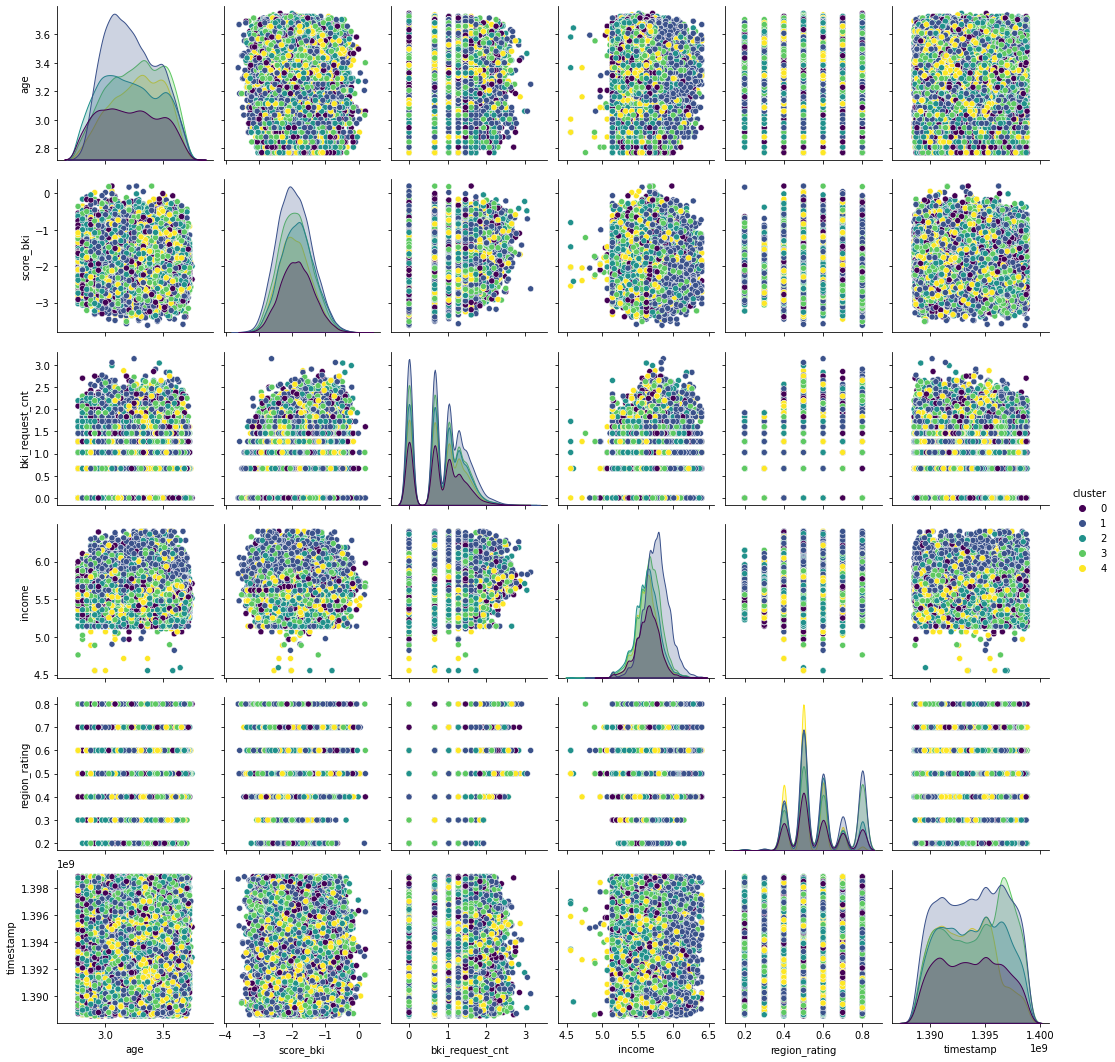

In [80]:
sns.pairplot(train[num_cols+['cluster']], hue = 'cluster', palette = 'viridis')

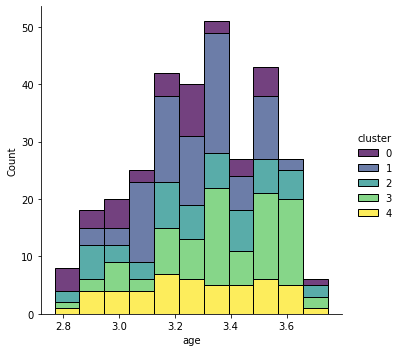

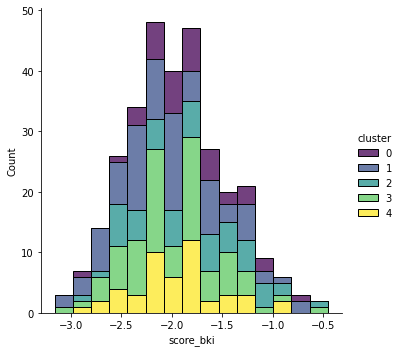

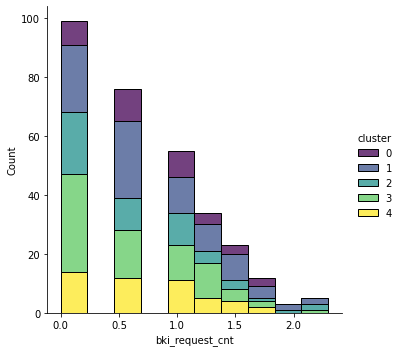

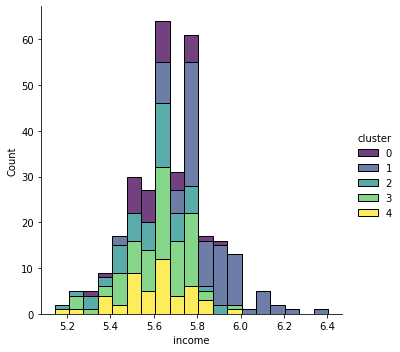

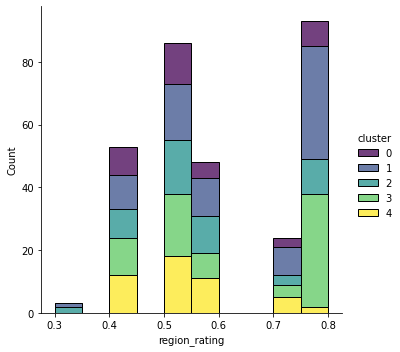

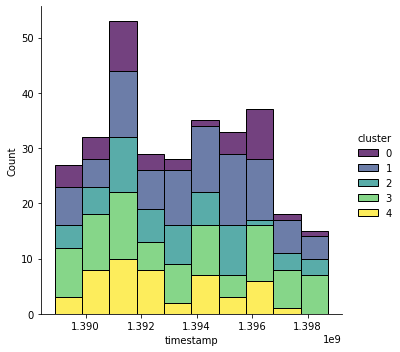

In [81]:
for col in num_cols:
    sns.displot(train[train.edu_isna == 1], x=col, hue='cluster', palette = 'viridis', multiple='stack')

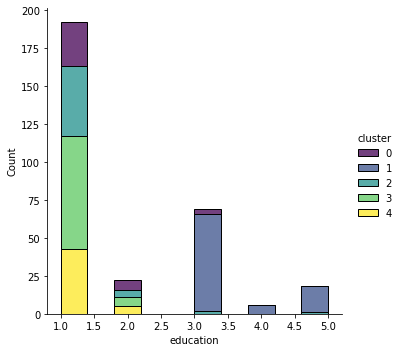

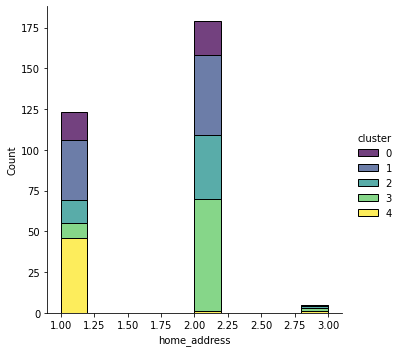

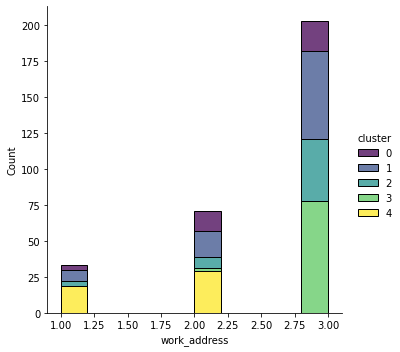

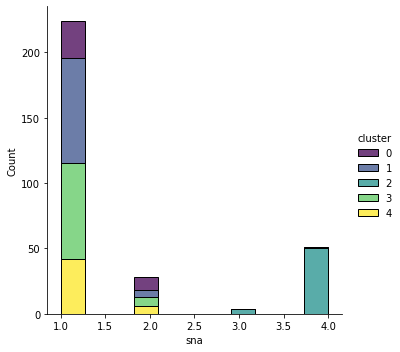

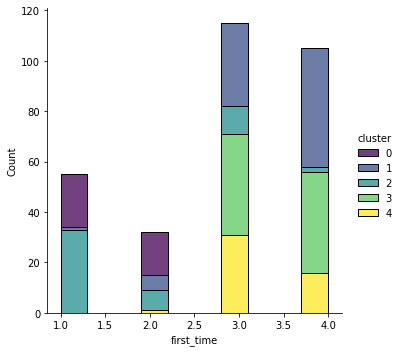

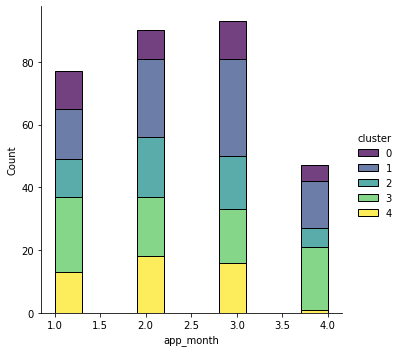

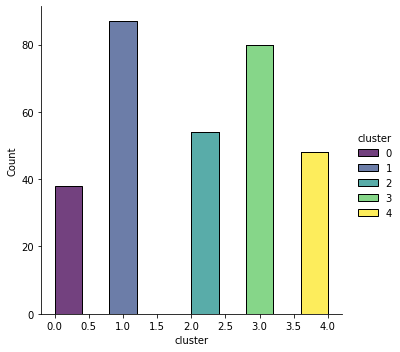

In [82]:
for col in cat_cols:
    sns.displot(train[train.edu_isna == 1], x=col, hue='cluster', palette = 'viridis', multiple='stack')

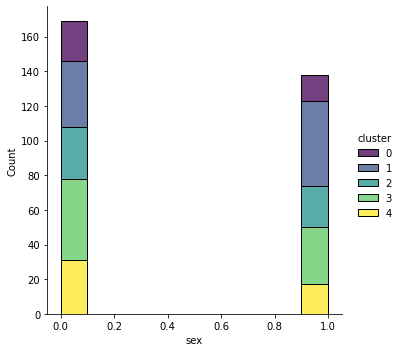

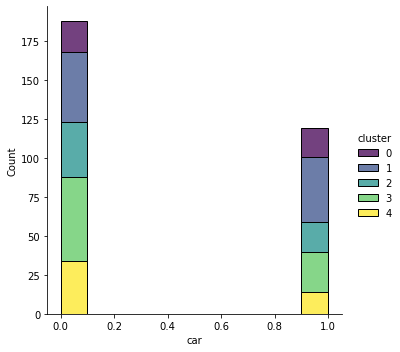

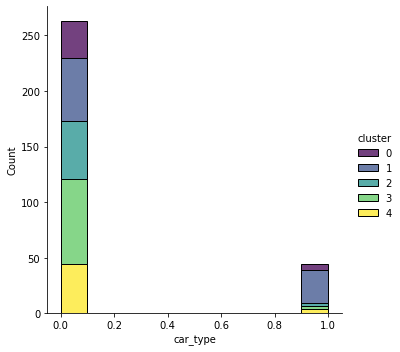

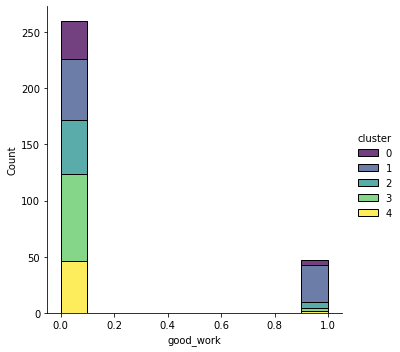

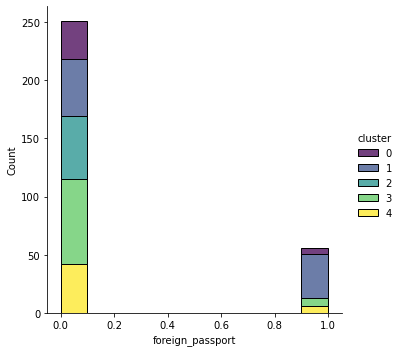

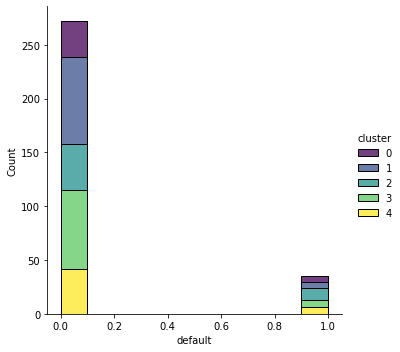

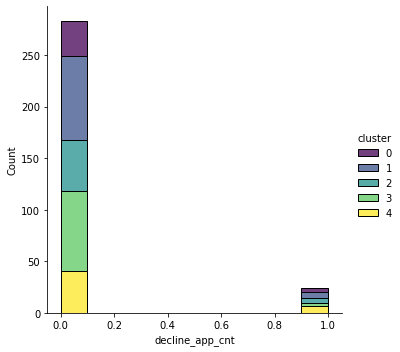

In [83]:
for col in bin_cols:
    sns.displot(train[train.edu_isna == 1], x=col, hue='cluster', palette = 'viridis', multiple='stack')

Визуально заметно:
- В кластере 4, привалируют люди с меньшим доходом
- В кластере 3 попадают люди с более низким образованием
- Для кластера 2 характерна сильная связь заемщика с клиентами банка (значения 1 и 2)
- В кластер 1, верхняя половина по доходам с относительно высоким образованием
- В кластере 0, заемщики со средним доходом, низким показателем 'first_time'

<AxesSubplot:>

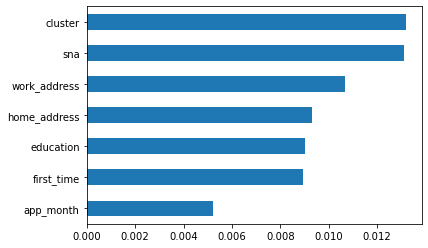

In [84]:
# Расчет взаимной иформации
features = train[cat_cols].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Итоговая переменная 'cluter' имеет большую взаимную информацию с целевой переменной по сравнению с остальными категориальными признаками, и несет ценность для модели.

## PCA

Метод главных компанент позволяет выявить перспективные пары признаков для создания новых

In [85]:
# Стандартизация числовых переменных, выделение целевой
A = StandardScaler().fit_transform(train[num_cols].values)
b = train.default

In [86]:
# Применение метода главных компанет
pca = PCA()
A_pca = pca.fit_transform(A)
component_names = [f"PC{i+1}" for i in range(A_pca.shape[1])]

A_pca = pd.DataFrame(A_pca, columns=component_names)
A_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6
0  1.489047  0.080595  0.339226  1.381956  0.664542 -0.029471
1  1.097981  0.900151  1.273215  0.052216  0.828360  0.042784
2 -1.802845  0.607494 -1.409473  0.188500  0.490279  1.096231
3  1.845447  0.646443  0.108447  1.288107  0.130398  0.890167
4 -0.021199  0.129554  0.771134 -1.152885  1.615480 -0.262676

<AxesSubplot:>

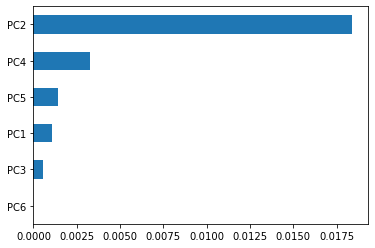

In [87]:
# Оцентка компанент
mi_scores = mutual_info_classif(A_pca, b, random_state = 100)
mi_scores = pd.Series(mi_scores, index=A_pca.columns)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Наибольшую ценность представляет компатеета 'PC2'. Так же, иммет смысл убедиться, что компатенты с более низким MI score не несут ценности. Для этих целей будет расмотрена так же 'PC1'.

### PC2

In [88]:
# Голова и хвост выборки, упорядоченной по 'PC2'
idx = A_pca['PC2'].sort_values(ascending=False).index
cols = num_cols

display(train.loc[idx, cols].head(10))
display(train.loc[idx, cols].tail(10))

age  score_bki  bki_request_cnt    income  region_rating  \
55405  3.060851  -0.223299         2.986413  5.708736            0.5   
33206  3.466398  -0.481892         3.043123  5.620854            0.5   
67718  3.060851  -0.702280         3.056436  5.829463            0.5   
47584  2.975565  -0.356936         2.297558  5.841720            0.5   
23064  2.975565  -0.484254         2.499029  5.560409            0.6   
35787  2.844680  -0.097323         1.727453  5.820880            0.5   
6657   2.808159  -0.348961         1.727453  5.560409            0.5   
71115  2.879550  -0.042827         1.921474  5.771906            0.6   
34067  3.496999  -0.263199         2.072081  5.460064            0.5   
14861  3.207100  -0.680085         2.499029  5.560409            0.5   

        timestamp  
55405  1391731200  
33206  1389139200  
67718  1391385600  
47584  1390003200  
23064  1390348800  
35787  1389916800  
6657   1388966400  
71115  1390694400  
34067  1390348800  
14861  1389484800

age  score_bki  bki_request_cnt    income  region_rating  \
16158  3.466398  -2.983168              0.0  5.685706            0.8   
67954  3.645626  -3.079144              0.0  5.742558            0.8   
39648  3.310398  -3.138558              0.0  5.908964            0.8   
12846  3.383819  -3.088781              0.0  6.024986            0.8   
7819   3.657744  -3.174842              0.0  5.713074            0.7   
61365  3.450606  -2.959679              0.0  6.016880            0.8   
34405  3.401091  -3.145981              0.0  5.797779            0.8   
13195  3.450606  -3.339817              0.0  5.878065            0.7   
61176  3.348017  -3.420154              0.0  5.609927            0.8   
34773  3.366134  -3.624586              0.0  5.841720            0.8   

        timestamp  
16158  1398643200  
67954  1396483200  
39648  1396224000  
12846  1395964800  
7819   1397433600  
61365  1397779200  
34405  1397952000  
13195  1396742400  
61176  1397088000  
34773  1398643200

Как видно из выборки упорядоченной по 'PC2', компанента основана на 'score_bki' и 'bki_request_cnt'.

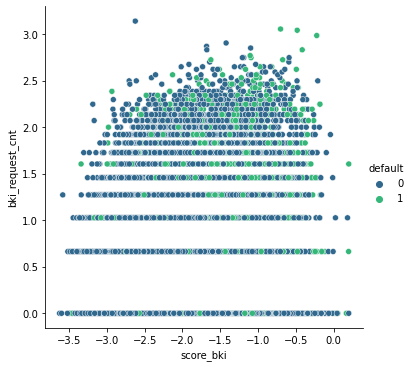

In [89]:
sns.relplot(data=train, x='score_bki', y='bki_request_cnt', hue='default', palette = 'viridis')

<AxesSubplot:ylabel='score_bki'>

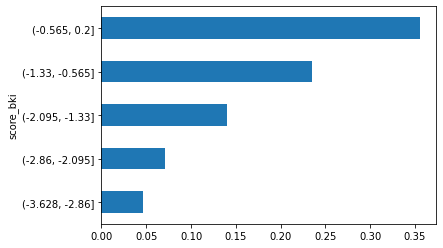

In [90]:
# Риск дефолта для категорий 'score_bki'
bins = pd.cut(train['score_bki'], bins=5)
train.groupby(bins).default.mean().plot(kind = 'barh')

<AxesSubplot:ylabel='bki_request_cnt'>

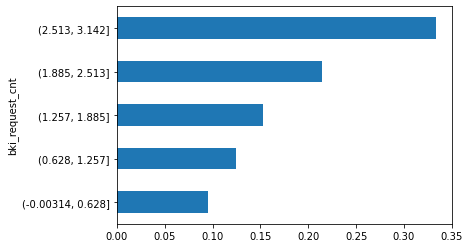

In [91]:
# Риск дефолта для категорий 'bki_request_cnt'
bins = pd.cut(train['bki_request_cnt'], bins=5)
train.groupby(bins).default.mean().plot(kind = 'barh')

Визуально, большее кол-во дефолтов характерно для клиентов с 'score_bki' близким к 0, и высоким 'bki_request_cnt'. Таким образом, новая переменная 'bki_ovrl' должна расти вместе с имеющимися.

Для этого, для 'score_bki' имеет смысл сместить минимум в 0. После чего полученный рейтинг будет помножен на 'bki_request_cnt'. Таким образом, макимальное значение 'bki_ovrl' достигается при большом количестве запросов в БКИ и плохом, с точки зрения риска дефоолта, рейтинге. Иными словами, метрика отбражает подтвержденный (многими запросами) плохой рейтинг заемщика.
(Расчет метрики через sin/cos 45 дает худший результат).

In [92]:
# Создание переменной
train['bki_ovrl'] = (train.score_bki - train.score_bki.min())*train.bki_request_cnt.values
num_cols.append('bki_ovrl')

<AxesSubplot:>

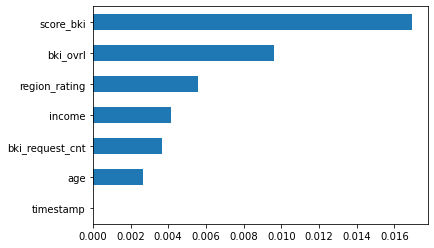

In [93]:
# Расчет взаимной иформации
features = train[num_cols].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

'bki_ovrl' показывает себя более полезной переменной, чем 'bki_request_cnt', но уступает 'score_bki'.

<AxesSubplot:ylabel='bki_ovrl'>

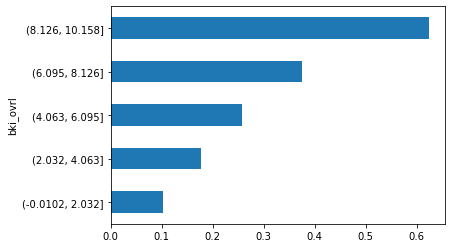

In [94]:
# Риск дефолта для категорий 'bki_ovrl'
bins = pd.cut(train['bki_ovrl'], bins=5)
train.groupby(bins).default.mean().plot(kind = 'barh')

Распределение риска дефолта ожидаемо сохраняется

<AxesSubplot:>

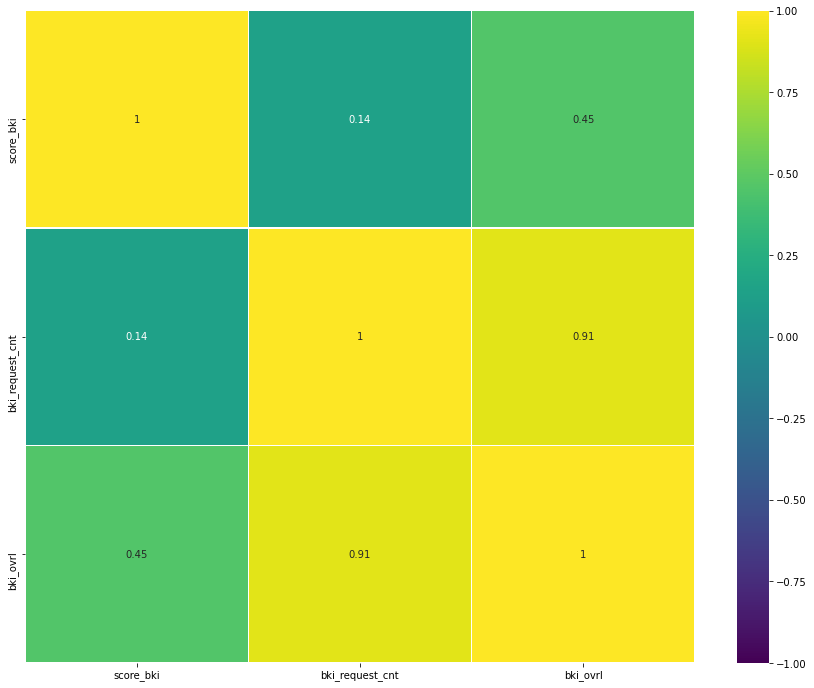

In [95]:
# Корреляционная матрица
f,ax = plt.subplots(figsize=(15, 12))
sns.heatmap(train[['score_bki','bki_request_cnt','bki_ovrl']].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

Корреляция между 'bki_ovrl' и 'bki_score' не привышает 0.5, в то время как корреляция с 'bki_request_cnt' слишком высока. Так как 'bki_ovrl' обладает большей общей информацией с 'default', 'bki_request_cnt' будет удален.

In [96]:
train.drop('bki_request_cnt', axis = 1, inplace = True)
num_cols.remove('bki_request_cnt')

### PC1

In [97]:
# Голова и хвост выборки, упорядоченной по 'PC1'
idx = A_pca['PC1'].sort_values(ascending=False).index
cols = num_cols

display(train.loc[idx, cols].head(20))
display(train.loc[idx, cols].tail(20))

age  score_bki    income  region_rating   timestamp  bki_ovrl
39339  3.645626  -2.417603  4.591533            0.5  1389571200  0.801420
60897  3.366134  -2.050431  4.713483            0.4  1395446400  0.000000
32795  3.005067  -2.547642  4.553056            0.5  1395878400  0.000000
15723  3.511833  -3.065449  5.227718            0.2  1388620800  0.000000
50114  3.161431  -2.397619  4.713483            0.4  1392681600  1.561802
37414  3.540629  -2.938221  5.292909            0.2  1396310400  0.000000
13960  3.645626  -3.037140  5.361027            0.2  1389916800  0.000000
12993  3.620765  -2.225993  5.272835            0.2  1397001600  0.928646
58099  2.912908  -2.024100  4.553056            0.5  1393372800  1.062700
7329   3.511833  -1.841759  5.227718            0.2  1390694400  0.000000
42595  3.366134  -1.470504  4.553056            0.6  1393459200  2.211293
66425  3.581799  -0.804162  4.553056            0.6  1396828800  4.872152
41474  3.645626  -2.390577  5.345544            0.2  1398816000  0.819364
28038  2.912908  -2.035382  4.553056            0.5  1397001600  2.022893
56975  3.645626  -3.064559  5.329111            0.3  1394668800  0.000000
19038  3.620765  -2.015339  5.155664            0.3  1395964800  1.651988
71729  3.568332  -3.022077  5.251188            0.3  1393459200  0.400058
57949  3.657744  -2.395925  5.369902            0.2  1393632000  0.815814
55347  3.595021  -2.053623  4.822272            0.6  1395014400  0.000000
71183  3.434468  -2.144353  5.300544            0.2  1391644800  0.000000

age  score_bki    income  region_rating   timestamp  bki_ovrl
51128  2.879550  -1.645158  6.151841            0.8  1393372800  2.519607
63868  3.060851  -2.548172  6.315415            0.8  1392854400  1.569376
26599  3.060851  -0.533459  6.187463            0.7  1391731200  7.499326
35025  2.975565  -2.063537  6.315415            0.8  1389225600  0.000000
58007  2.944877  -0.788336  6.047405            0.8  1389484800  6.058859
12338  3.161431  -1.546403  6.282872            0.8  1398124800  3.029920
734    3.137514  -1.467055  6.216927            0.8  1389916800  4.145639
27277  2.944877  -2.187783  6.282872            0.8  1397174400  1.474964
28538  3.434468  -0.830718  6.275479            0.8  1392940800  6.419073
57777  3.184612  -1.120546  6.241975            0.8  1397001600  4.325612
39312  2.912908  -1.662139  6.151841            0.8  1390780800  4.066351
31350  3.250147  -0.901733  6.282872            0.8  1389312000  2.795170
67626  3.348017  -0.726791  6.394086            0.7  1389052800  5.568038
28237  3.087277  -1.204975  6.187463            0.8  1390176000  5.439660
68639  2.975565  -0.757121  6.151841            0.8  1389744000  3.649986
22049  3.184612  -0.923618  6.241975            0.8  1389830400  5.404690
34003  2.912908  -1.445605  6.315415            0.8  1396396800  0.000000
5755   3.450606  -0.210194  6.282872            0.8  1396224000  8.532667
67011  3.310398  -1.394748  6.375477            0.8  1396310400  4.620406
22357  3.087277  -1.204858  6.365216            0.8  1393545600  2.483995

Как видно из выборки упорядоченной по 'PC1', компанента основана на 'income' и 'region_rating'.

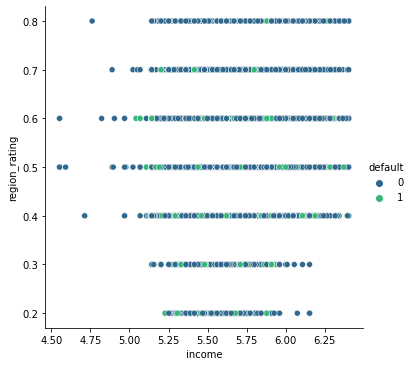

In [98]:
sns.relplot(data=train, x='income', y='region_rating', hue='default', palette = 'viridis')

<AxesSubplot:ylabel='income'>

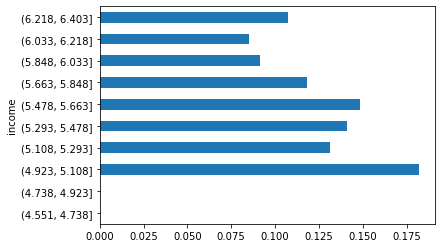

In [99]:
# Риск дефолта для категорий 'income'
bins = pd.cut(train['income'], bins=10)
train.groupby(bins).default.mean().plot(kind = 'barh')

<AxesSubplot:ylabel='region_rating'>

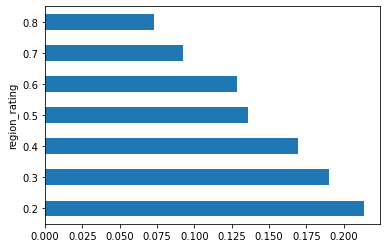

In [100]:
# Риск дефолта для 'region_rating'
train.groupby('region_rating').default.mean().plot(kind = 'barh')

Визуально, для регионов с более высоким рейтингом, риск дефолта ниже. Что касается, доходов, существует тренд к снижению риска с увеличением дохода, но его нельзя назвать устойчивым. В частности, категория людей с наиболее низким доходом не склонна к дефолту. Новая переменная 'relational_wealth' будет отбражать отношение уровеня дохода к рейтингу региона, который может быть объяснен его благосостоянием.

In [101]:
train['relational_wealth'] = train.income/train.region_rating
num_cols.append('relational_wealth')

<AxesSubplot:>

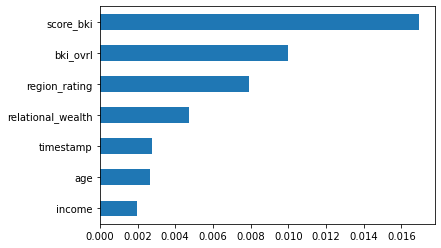

In [102]:
# Расчет взаимной иформации
features = train[num_cols].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

'relational_wealth' показывает себя более полезной переменной по сравнению с 'income' и 'region_rating'.

<AxesSubplot:ylabel='relational_wealth'>

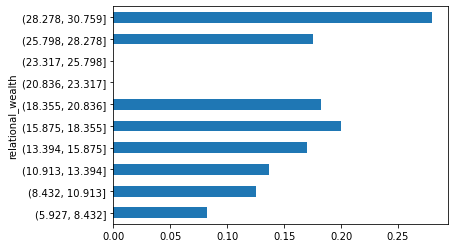

In [103]:
# Риск дефолта для категорий 'relational_wealth'
bins = pd.cut(train['relational_wealth'], bins=10)
train.groupby(bins).default.mean().plot(kind = 'barh')

Судя по полученному графику, в регионах с низким рейтингом, для относительно богатых людей, риск дефолта выше. В то же время, люди с низким доходом, прожиающие в регионах с низким рейтингом, наименне склоны к дефолоту.

<AxesSubplot:>

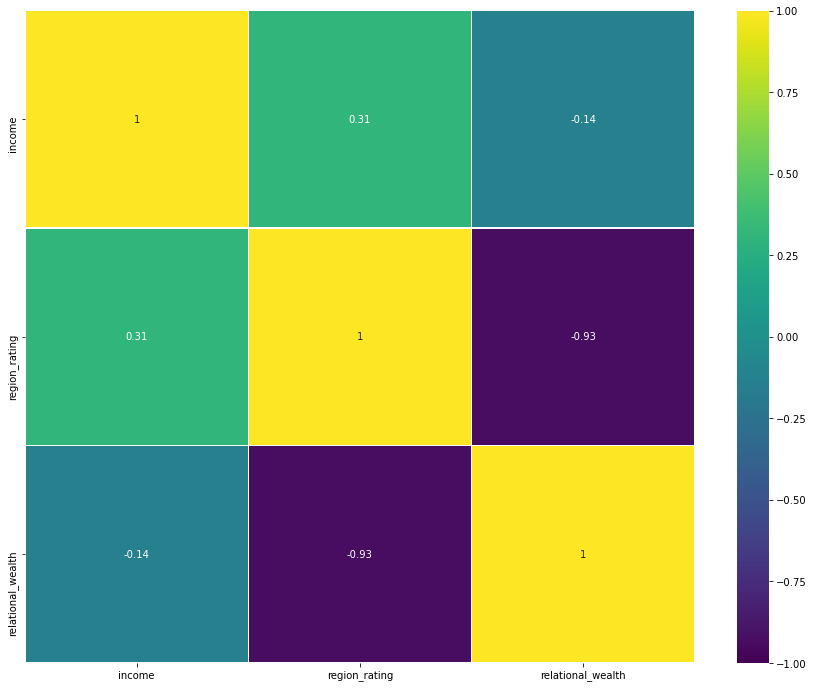

In [104]:
# Корреляционная матрица
f,ax = plt.subplots(figsize=(15, 12))
sns.heatmap(train[['income','region_rating','relational_wealth']].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

Корреляция между 'relational_wealth' и 'income' не привышает 0.5, в то время как корреляция с 'region_rating' слишком высока.

Так же, 'relational_wealth' показал худший MI score. Нет достаточных оснований заменять оригинальные данные 'region_rating' с четкой линейной зависимостью.

In [105]:
train.drop('relational_wealth', axis = 1, inplace = True)
num_cols.remove('relational_wealth')

## Создание переменных на основе логики

### reliable_cust

Переменная на основе давности наличия информации о заемщике ('first_time') и связи заемщика с клиентами банка ('sna')

FIRST_TIME
3(%%):	42.35152237835201
	 default rate(%%):	12.026875699888018
4(%%):	25.389232916435184
	 default rate(%%):	8.203020761061003
1(%%):	16.58423555874741
	 default rate(%%):	18.612631750960045
2(%%):	15.6750091464654
	 default rate(%%):	15.542876901798063
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

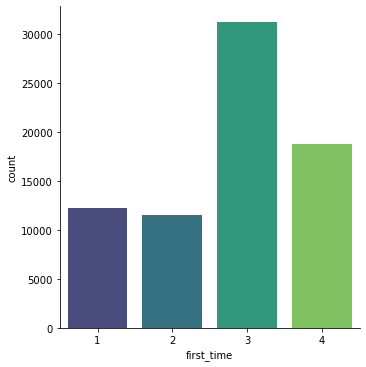

SNA
1(%%):	64.09436442228214
	 default rate(%%):	9.820088370224731
4(%%):	15.920269922356672
	 default rate(%%):	21.15073623287088
2(%%):	14.398569086301983
	 default rate(%%):	14.982119329945418
3(%%):	5.586796569059201
	 default rate(%%):	15.765219500363814
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

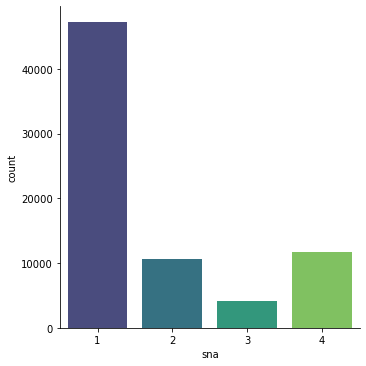

In [106]:
for col in ['first_time','sna']:
    summary(train, col)

default rate уменьшается для 'first time' и увеличивается для 'sna'

In [107]:
# Создание переменной
train['reliable_cust'] = train.first_time - train.sna

RELIABLE_CUST
2(%%):	31.627799834686105
	 default rate(%%):	10.029561715436357
3(%%):	22.833642732286346
	 default rate(%%):	7.435760488991751
1(%%):	14.700741202455317
	 default rate(%%):	13.770854456631948
0(%%):	10.032656269055137
	 default rate(%%):	16.166936790923824
-3(%%):	9.491998536565536
	 default rate(%%):	19.82869379014989
-1(%%):	7.857830051897722
	 default rate(%%):	20.831177789274015
-2(%%):	3.4553313730538355
	 default rate(%%):	19.215686274509807
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

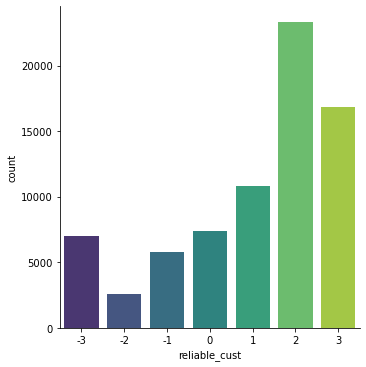

In [108]:
summary(train, 'reliable_cust')

<AxesSubplot:>

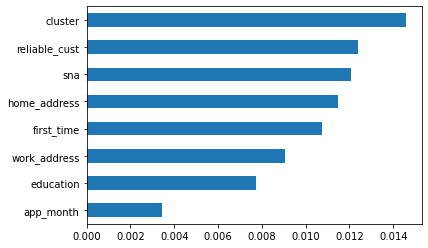

In [109]:
# Расчет взаимной иформации
features = train[cat_cols+['reliable_cust']].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Переменная 'reliable_cust' показывает более высокий MI score.

In [110]:
cat_cols.append('reliable_cust')

### travel_time

Переменная на основе домашнего адреса ('home_address') и адреса работы ('work_address'). Нет ясности как закодирован признак. Для дальнейшей работы, будем считать, что оба признака обозначают зоны удалености от определенной зоны (к примеру, центр города). В таком случае, разница по модулю между 'home_address' и 'work_address' обозначает частые перемещения между зонами.

In [111]:
# Создание переменной
train['travel_time'] = train.home_address - train.work_address
train['travel_time'] = train.travel_time.apply(lambda x: -x if x<0 else x)

TRAVEL_TIME
1(%%):	79.10405290044581
	 default rate(%%):	13.798006098187674
0(%%):	13.871461672922397
	 default rate(%%):	8.459509621959558
2(%%):	7.024485426631798
	 default rate(%%):	8.699845679012345
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

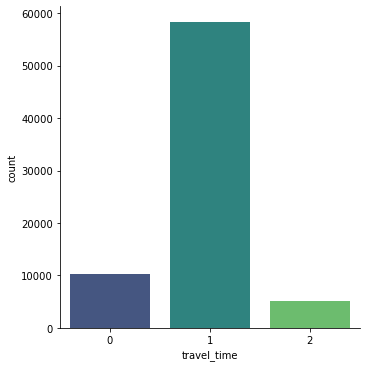

In [112]:
summary(train, 'travel_time')

<AxesSubplot:>

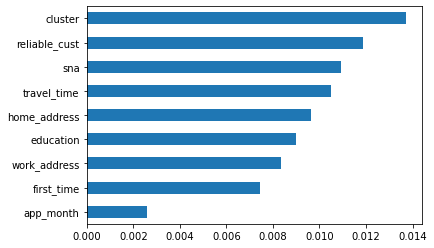

In [113]:
# Расчет взаимной иформации
features = train[cat_cols+['travel_time']].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Переменная 'travel_time' показывает более высокий MI score.

In [114]:
cat_cols.append('travel_time')

### income_to_expenses

Переменная на основе дохода заемщика ('first_time') поделенная на кол-во потенциальных иточников трат на авто и заграничные поездки ('car', 'car_type', 'foreign_passport').

In [115]:
# Создание переменной
train['income_to_expenses'] = train.income/(1+train.car+train.car_type+train.foreign_passport)

INCOME_TO_EXPENSES
mean    4.272747
std     1.658575
min     1.285695
25%     2.780204
50%     5.479840
75%     5.661892
max     6.402578
Name: income_to_expenses, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



<Figure size 432x288 with 0 Axes>

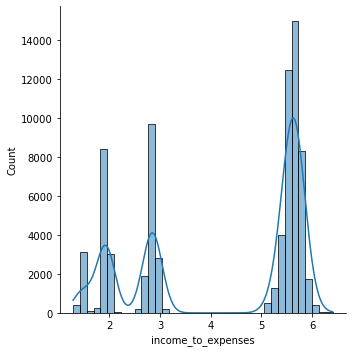

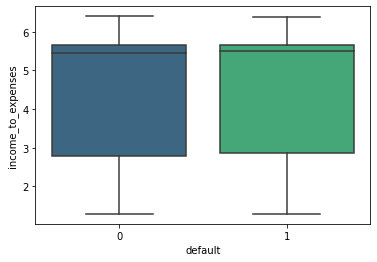

In [116]:
sum_up(train, 'income_to_expenses')

<AxesSubplot:>

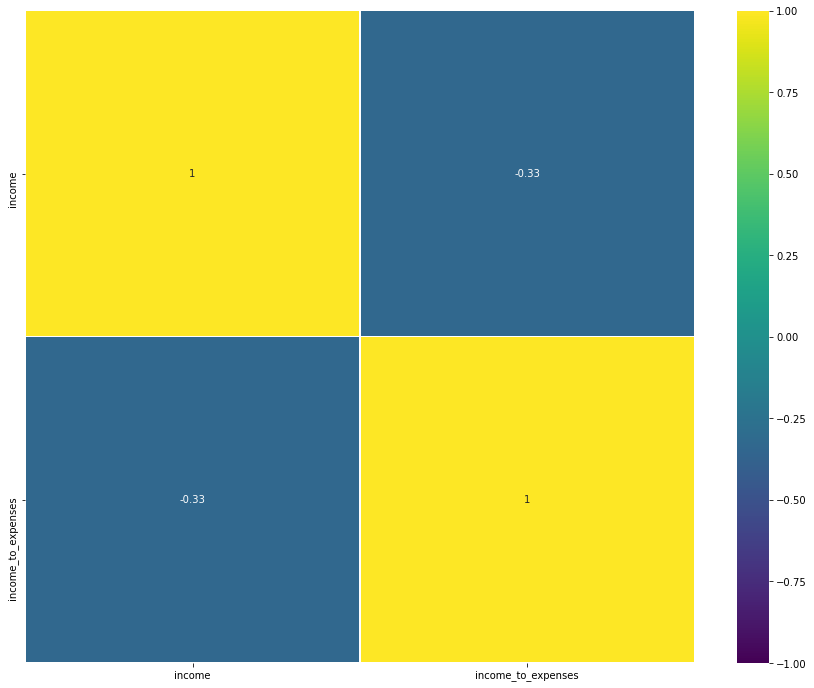

In [117]:
# Корреляционная матрица
f,ax = plt.subplots(figsize=(15, 12))
sns.heatmap(train[['income','income_to_expenses']].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

<AxesSubplot:>

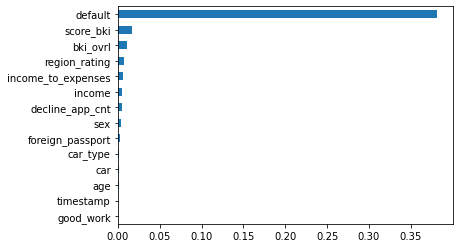

In [118]:
# Расчет взаимной иформации
features = train[bin_cols+num_cols+['income_to_expenses']].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Переменная 'income_to_expenses' показывает более высокий MI score. Корреляция с 'income' в пределах нормы.

In [119]:
num_cols.append('income_to_expenses')

### relative_edu

Переменная на основе уровне образования ('education') и возрасте ('age') заемщика, и отображает относительный уровень образования

In [120]:
# Создание переменной
train['relative_edu'] = train.education/train.age

RELATIVE_EDU
mean    0.570599
std     0.304014
min     0.266809
25%     0.302078
50%     0.347277
75%     0.891230
max     1.805165
Name: relative_edu, dtype: float64
Кол-во выбросов: 1 	 (%%: 0.001355031911001504)



<Figure size 432x288 with 0 Axes>

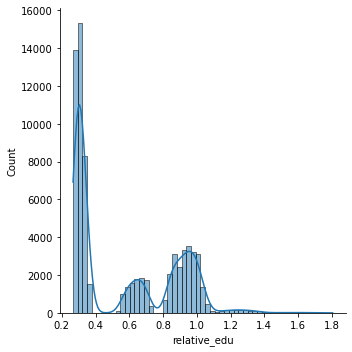

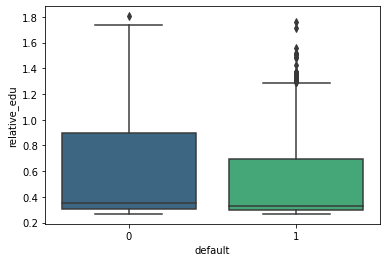

In [121]:
sum_up(train, 'relative_edu')

In [122]:
train['relative_edu'] = stats.boxcox(train['relative_edu'])[0]

RELATIVE_EDU
mean   -0.980009
std     0.774523
min    -1.962801
25%    -1.710098
50%    -1.446616
75%    -0.118976
max     0.502305
Name: relative_edu, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



<Figure size 432x288 with 0 Axes>

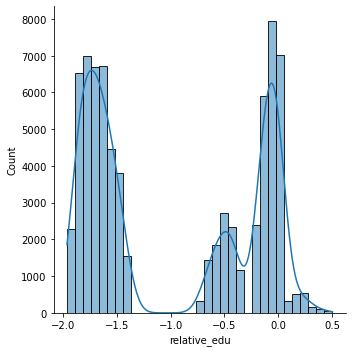

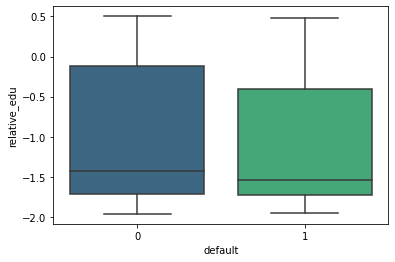

In [123]:
sum_up(train, 'relative_edu')

<AxesSubplot:>

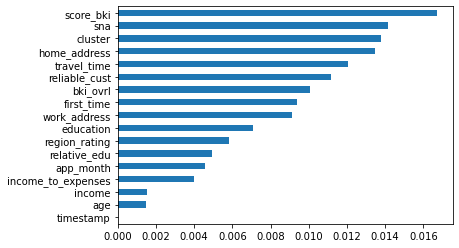

In [124]:
# Расчет взаимной иформации
features = train[cat_cols+num_cols+['relative_edu']].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

<AxesSubplot:>

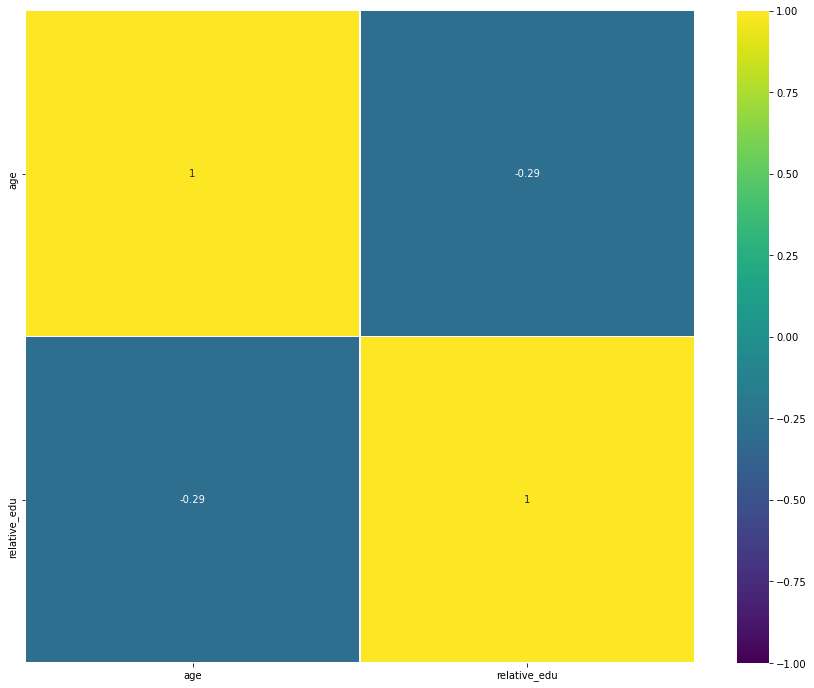

In [125]:
# Корреляционная матрица
f,ax = plt.subplots(figsize=(15, 12))
sns.heatmap(train[['age','relative_edu']].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

Переменная 'income_to_expenses' не дает прибавки в общей информации по сравнению с 'education' и может быть удалена.

In [126]:
train.drop('relative_edu', axis = 1, inplace = True)

## Создание агрегированных переменных путем перекодировки

### bin_cat_rating

Рейтинг на основе бинарных и категориальных переменных. За основу взята линейная зависимость между значениями признака и default rate. Из суммы переменных с положинельной линейной зависимостью вычетаются переменные с отрицательной линейной зависимостью. Категория 'home_address' не включена, т. к. в этом случае линейная зависимость отсутствует.

In [127]:
# Создание переменной
train['bin_cat_rating'] = train[['car', 'car_type', 'good_work', 'foreign_passport',
                                 'education', 'first_time', 'app_month']].sum(axis=1) - train[['sex', 'decline_app_cnt', 
                                                                                               'work_address', 'sna']].sum(axis=1)

In [128]:
# Необязательный сдвиг переменной, чтобы рейтинг был от 1го до 20ти
train['bin_cat_rating'] = train['bin_cat_rating'] + 7

BIN_CAT_RATING
mean    10.126181
std      3.031107
min      1.000000
25%      8.000000
50%     10.000000
75%     12.000000
max     20.000000
Name: bin_cat_rating, dtype: float64
Кол-во выбросов: 91 	 (%%: 0.12330790390113688)



<Figure size 432x288 with 0 Axes>

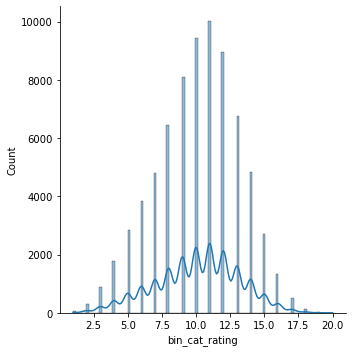

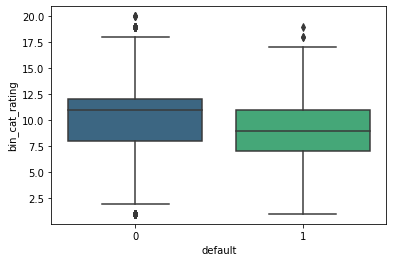

In [129]:
sum_up(train, 'bin_cat_rating')

<AxesSubplot:>

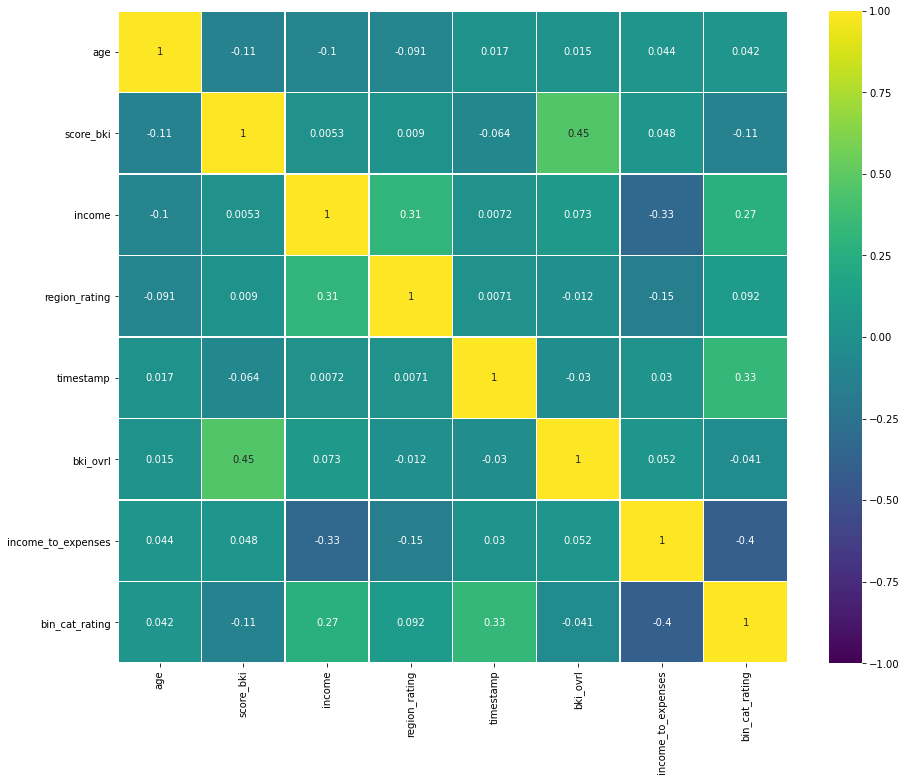

In [130]:
# Корреляционная матрица
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(train[num_cols+['bin_cat_rating']].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

<AxesSubplot:>

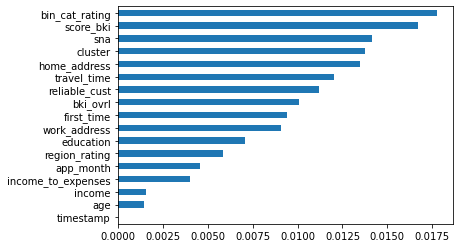

In [131]:
# Расчет взаимной иформации
features = train[cat_cols+num_cols+['bin_cat_rating']].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Переменная 'bin_cat_rating' показывает ввысокий MI score. При этом, корреляция со 'score_bki' (вторым по полезности признаком) низкая. Распределение переменной нормально. Имеется незначительное кол-во выбросов.

In [132]:
num_cols.append('bin_cat_rating')

### num_category

Переменная на основе числовых данных (age','income','region_rating','score_bki'). За основу взята разница в средних значениях для дефолтных и недефолтных клиентов. Каждое значение сравнивается с медианой признака. Если значение попадает в половину с более низким default rate, клиент повышается в классе.

In [133]:
# Вспомогательный 
nt_help = pd.DataFrame({'median':[1.0,1.0,1.0,1.0]}, index = ['age','income','region_rating','score_bki'])
for i in nt_help.index:
    nt_help.loc[i]['median'] = train[i].median()
nt_help

median
age            3.228933
income         5.668952
region_rating  0.500000
score_bki     -1.920823

In [134]:
# Вспомогательный справочник для быстродействия num_transform
nt_help = pd.Series([1.0,1.0,1.0,1.0], index = ['age','income','region_rating','score_bki'], name = 'Medians')
for i in nt_help.index:
    nt_help.loc[i] = train[i].median()
nt_help

age              3.228933
income           5.668952
region_rating    0.500000
score_bki       -1.920823
Name: Medians, dtype: float64

In [135]:
# Функция возвращает значение 'num_category' для строки
def num_transform(raw):
    count = 0
    for col in ['age','income','region_rating']:
        if raw[col] > nt_help[col]:
            count += 1
    if raw['score_bki'] < nt_help['score_bki']:
        count += 1
    return count

In [136]:
# Создание переменной
train['num_category'] = train.apply(num_transform, axis = 1)

NUM_CATEGORY
2(%%):	35.69560563151262
	 default rate(%%):	11.661541965607562
1(%%):	26.671093104242605
	 default rate(%%):	16.968957984047147
3(%%):	22.46778411631594
	 default rate(%%):	7.906640130269587
0(%%):	8.771121559912736
	 default rate(%%):	21.70554611463
4(%%):	6.394395588016098
	 default rate(%%):	5.170586988768807
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

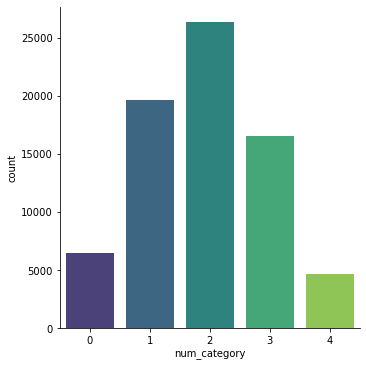

In [137]:
summary(train, 'num_category')

<AxesSubplot:>

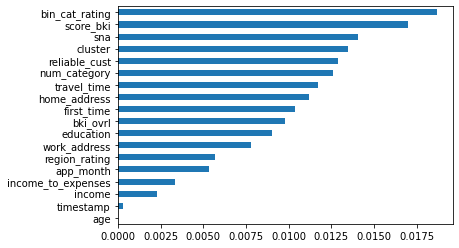

In [138]:
# Расчет взаимной иформации
features = train[cat_cols+num_cols+['num_category']].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Переменная 'num_category' показывает высокий для категориальной переменной MI score.

In [139]:
cat_cols.append('num_category')

## Итог

Не смотря на то, что созданные переменные показывают относительно высокий MI score, на тестовой выборке нет заметного улучшения метрик модели. Тем не менее, на валидационной выборке (Kaggle), есть итоговое улучшение ROC AUC

In [140]:
bin_cols.remove('default')

<AxesSubplot:>

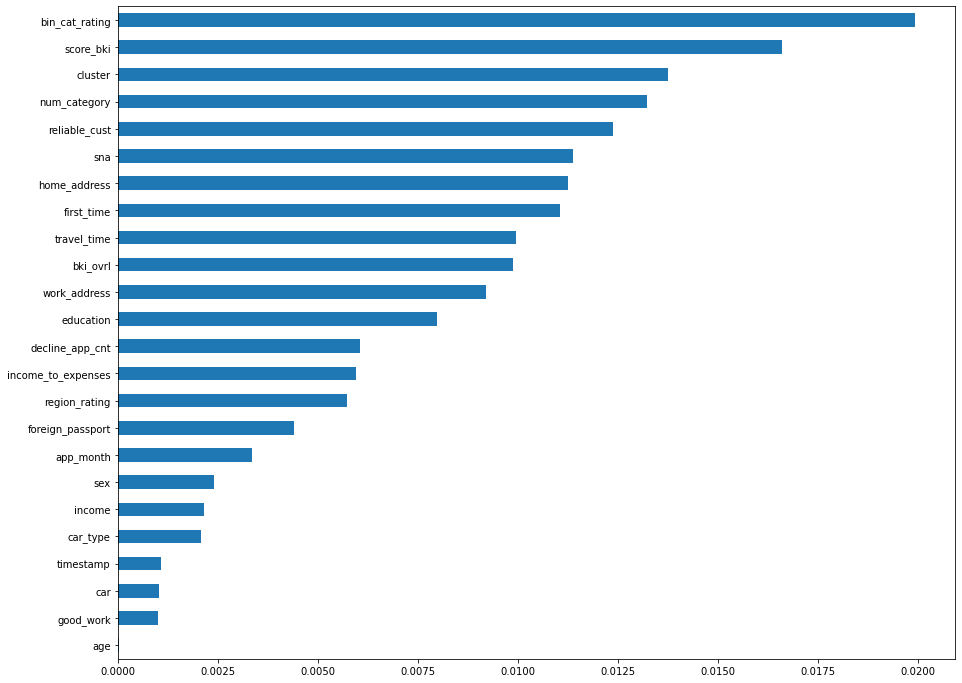

In [141]:
# Расчет взаимной иформации
features = train[cat_cols+num_cols+bin_cols].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh', figsize=(15, 12))

In [142]:
train.sample(5)

education  sex       age  car  car_type  decline_app_cnt  good_work  \
51418        1.0    1  3.005067    1         1                0          0   
52803        3.0    0  3.329446    1         1                0          0   
21881        3.0    0  3.496999    0         0                0          0   
27129        1.0    0  3.270776    0         0                0          0   
61491        3.0    0  2.844680    0         0                0          0   

       score_bki  region_rating  home_address  ...  app_month   timestamp  \
51418  -2.345486            0.5             1  ...          2  1393545600   
52803  -2.071408            0.5             2  ...          4  1396569600   
21881  -2.175563            0.8             2  ...          4  1398038400   
27129  -2.261909            0.6             1  ...          3  1395532800   
61491  -1.214514            0.5             2  ...          4  1397520000   

       edu_isna  cluster  bki_ovrl  reliable_cust  travel_time  \
51418         0        2  1.313072             -1            0   
52803         0        1  1.977036              3            1   
21881         0        1  1.487509              3            1   
27129         0        4  0.000000              0            0   
61491         0        2  2.474082             -1            1   

       income_to_expenses  bin_cat_rating  num_category  
51418            1.923969             9.0             2  
52803            1.889651            16.0             2  
21881            5.797779            14.0             4  
27129            5.620854            10.0             3  
61491            5.620854            10.0             0  

[5 rows x 26 columns]

# Model

In [143]:
# Создание предобработок данных
main_OHE = OneHotEncoder(sparse = False).fit(train[cat_cols].values)
main_SS = StandardScaler().fit(train[num_cols].values)

In [144]:
# Предобработка
X_cat = main_OHE.transform(train[cat_cols].values)
X_num = main_SS.transform(train[num_cols].values)
X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

In [145]:
# Разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [146]:
# Создание модели
model = LogisticRegression(random_state=100)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

### ROC AUC
Площадь под кривой. Метрика отбражает вероятность предсказать правильное значение (y), относительно ошибки (x). Теоретический максимум = 1, значение рандома = 0.5.

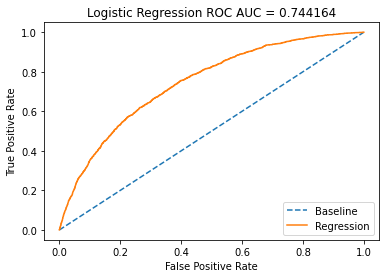

In [147]:
# Рассчет и визуализация ROC AUC
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### Дополнительные метрики

- Accuracy: (TN+TP)/(TP+TN+FP+FN) - отношение верно предсказанных к общему кол-ву объектов
- Precision: TP/(TP+FP) - сколько из значений, предсказаных позитивными, являются таковыми
- Recall: TP/(TP+FN) - доля из всех положительных, предсказанная верно
- F1 score: 2*Precision*Recall/(Precision+Recall) - среднее гармоническое между двумя вышеописанными метриками

Accuracy: 		 0.8753387533875339
Precision: 		 0.4424778761061947
Recall: 		 0.02736726874657909
F1 score: 		 0.051546391752577324
Confusion matrix:


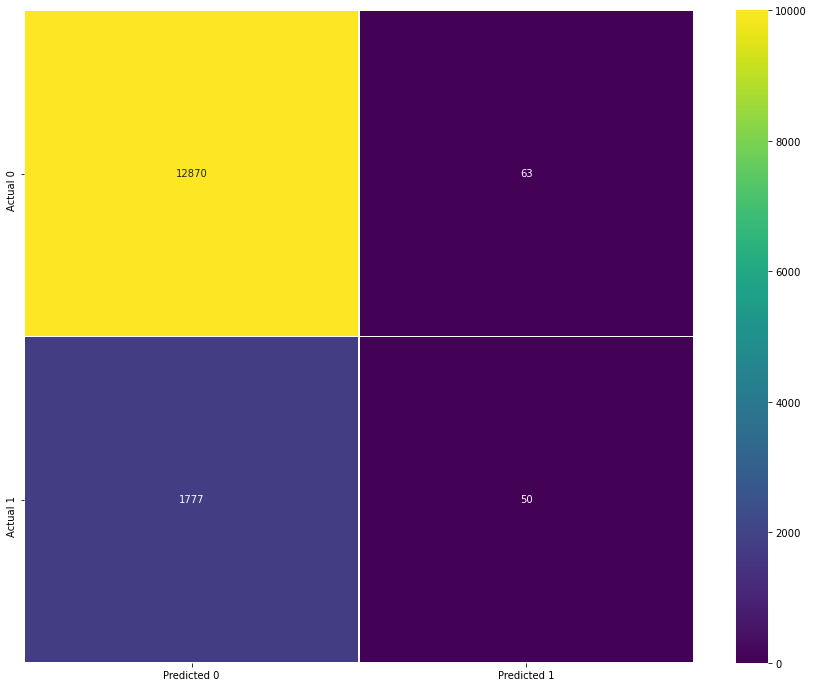

In [148]:
# Дополнительные метрики
print('Accuracy: \t\t', accuracy_score(y_test, predictions))
print('Precision: \t\t', precision_score(y_test, predictions))
print('Recall: \t\t', recall_score(y_test, predictions))
print('F1 score: \t\t', f1_score(y_test, predictions))

print('Confusion matrix:')
plt.figure(figsize=(15, 12))
matrix = pd.DataFrame(confusion_matrix(y_test, predictions), 
                      columns=[f"Predicted {i}" for i in range(0, 2)], 
                      index = [f"Actual {i}" for i in range(0, 2)])
sns.heatmap(matrix, vmin=0, vmax=10000, annot=True, linewidths=.5, cmap='viridis', fmt='d')
plt.show()

### Промежуточный вывод

Не смотря на довольно высокий ROC AUC, модель не несет практической ценности, так как крайне редко предсказывает дефолт у клиентов (2.74%% от общего числа дефолтных клиентов). Применение данной модели несет в себе недооцентку риска дефолта и может привести к убыткам.

Данный дисбаланс в предсказаниях можно исправить, устранив дисбаланс выборки

## Oversampling

In [149]:
# Функция возвращает сбалансированную выборку для бинарной переменной
def bin_oversampling(df, col):
    vc = df[col].dropna().value_counts(ascending=False)
    value = vc.max()
    parts =[]
    parts.append(df[df[col]==vc.index[0]])
    for i in range(int(vc.max()/vc.min())):
        parts.append(df[df[col]==vc.index[1]])
    parts.append(df[df[col]==vc.index[1]].head(vc.max()%vc.min()))
    sample = pd.concat(parts)
    return sample

DEFAULT
0(%%):	50.0
	 default rate(%%):	0.0
1(%%):	50.0
	 default rate(%%):	100.0
Статистически значимые различия не найдены. Данные не несут ценности.


<Figure size 432x288 with 0 Axes>

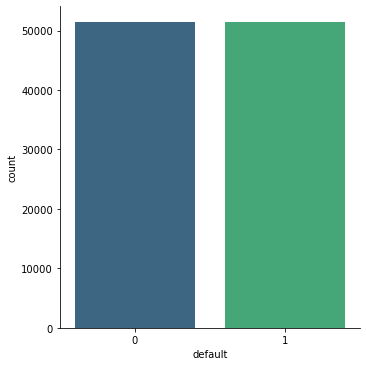

In [150]:
# Преобразование тренировочной выборки, визуализация
unbalanced = pd.DataFrame(X_train)
unbalanced['default'] = y_train
sample = bin_oversampling(unbalanced, 'default')
summary(sample, 'default')

In [151]:
# Сбалансированная обучающая выборка
blncd_X_train = sample.copy().drop('default', axis = 1).values
blncd_y_train = sample['default'].copy().values

In [152]:
# Заново обучаем модель и делаем предсказания
model = LogisticRegression(random_state=100)
model.fit(blncd_X_train, blncd_y_train)
predictions = model.predict(X_test)

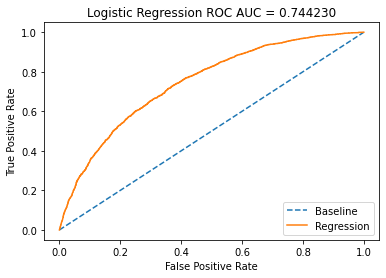

In [153]:
# Рассчет и визуализация ROC AUC
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Accuracy: 		 0.6721544715447154
Precision: 		 0.22558309037900875
Recall: 		 0.6776135741652983
F1 score: 		 0.3384825700615175
Confusion matrix:


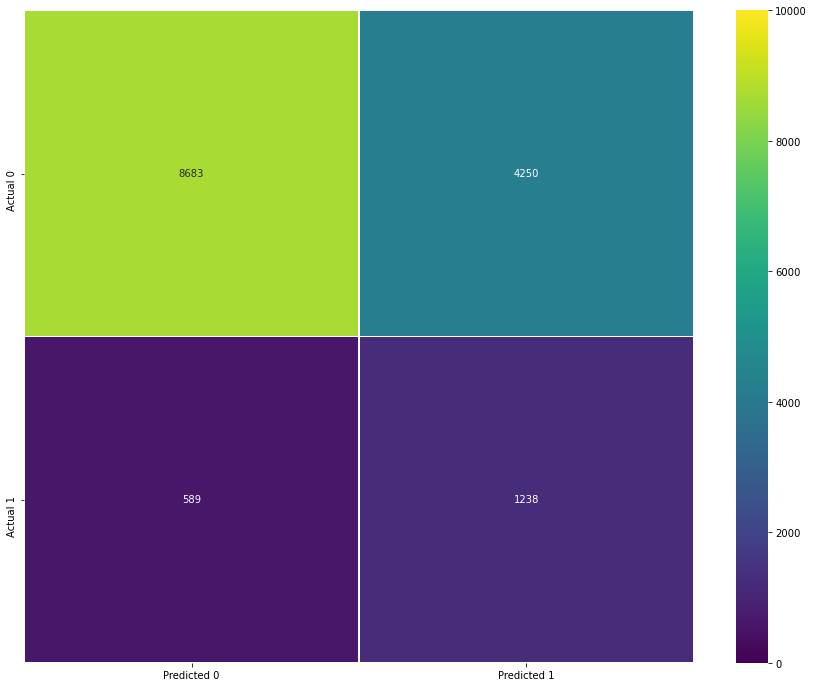

In [154]:
# Дополнительные метрики
print('Accuracy: \t\t', accuracy_score(y_test, predictions))
print('Precision: \t\t', precision_score(y_test, predictions))
print('Recall: \t\t', recall_score(y_test, predictions))
print('F1 score: \t\t', f1_score(y_test, predictions))

print('Confusion matrix:')
plt.figure(figsize=(15, 12))
matrix = pd.DataFrame(confusion_matrix(y_test, predictions), 
                      columns=[f"Predicted {i}" for i in range(0, 2)], 
                      index = [f"Actual {i}" for i in range(0, 2)])
sns.heatmap(matrix, vmin=0, vmax=10000, annot=True, linewidths=.5, cmap='viridis', fmt='d')
plt.show()

### Промежуточный вывод

После изменения обучающей выборки, целевая метрика (ROC AUC) осталась примерно прежней. Снизились accuracy и precision, но значительно вырос recall. Иными словами, модель усиленно ищет дефолтных клиентов:
- только 22.5% от клиентов, предсказанных как дефолтные, оказываются таковыми на самом деле.
- вместе с тем, дефолтных клиентов модель спобна предсказать в 68% случаев.

Данный консервативный подход больше подходит для внедрения модели.

(Ручная балансировка выборки дала чуть лучший recall по сравнению с гиперпараметром class_weight = 'balanced', встроенным в модель)

## Подбор гиперпараметров модели для максимизации ROC AUC

In [155]:
# Значения гиперпараметров для тестирования
C = [0.01, 0.1, 1, 10]
class_weight = [{1: 0.5, 0: 0.5}, {1: 0.66, 0: 0.34}, {1: 0.75, 0: 0.25}]
penalty = ['l1', 'l2']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']


# Словарь гиперпараметров
hyperparameters = {'C': C,  'class_weight': class_weight,
                   'penalty': penalty, 'solver': solver}

model = LogisticRegression(random_state=100, max_iter=20)
model.fit(blncd_X_train, blncd_y_train)

# Создаем сетку поиска с использованием 3-кратной перекрестной проверки
gscv = GridSearchCV(model, hyperparameters, cv=3,
                   verbose=1.1, scoring='roc_auc')
best_model_gscv = gscv.fit(blncd_X_train, blncd_y_train)

print()
print('Лучший ROC AUC: \t', best_model_gscv.best_score_)
print()
for parameter in hyperparameters.keys():
    print('Лучший {}:\t'.format(parameter.upper()),
          best_model_gscv.best_estimator_.get_params()[parameter])

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=sag; tota

[CV] END C=0.01, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=sag; total time=   0.9s
[CV] END C=0.01, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=saga; total time=   1.1s
[CV] END C=0.01, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=saga; total time=   1.1s
[CV] END C=0.01, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=saga; total time=   1.2s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, so

[CV] END C=0.1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=0.1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=sag; total time=   1.1s
[CV] END C=0.1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=sag; total time=   1.1s
[CV] END C=0.1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=sag; total time=   1.1s
[CV] END C=0.1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=saga; total time=   1.2s
[CV] END C=0.1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=saga; total time=   1.2s
[CV] END C=0.1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=saga; total time=   1.2s
[CV] END C=1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=l

[CV] END C=1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=sag; total time=   1.1s
[CV] END C=1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=sag; total time=   1.1s
[CV] END C=1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=sag; total time=   1.1s
[CV] END C=1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=saga; total time=   1.2s
[CV] END C=1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=saga; total time=   1.2s
[CV] END C=1, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=saga; total time=   1.2s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg;

[CV] END C=10, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=10, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=10, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=10, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=sag; total time=   1.1s
[CV] END C=10, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=sag; total time=   1.1s
[CV] END C=10, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=sag; total time=   1.1s
[CV] END C=10, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=saga; total time=   1.2s
[CV] END C=10, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=saga; total time=   1.2s
[CV] END C=10, class_weight={1: 0.75, 0: 0.25}, penalty=l2, solver=saga; total time=   1.2s

Лучший ROC AUC: 	 0.734731554341885

Лучший C:	 10
Лучший CLASS_WEIGHT:	 {1: 0.5, 0: 0.5}
Лучший PENALTY:	 l1
Лучший SOLVER:	 liblinear


In [159]:
# Значения гиперпараметров для тестирования
C = [0.01, 0.1, 1, 10]
class_weight = [{1: 0.5, 0: 0.5}, {1: 0.66, 0: 0.34}]
penalty = ['l1', 'l2']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
warm_start = [True, False]

# Словарь гиперпараметров
hyperparameters = {'C': C,  'class_weight': class_weight, 'penalty': penalty, 
                   'solver': solver, 'warm_start':warm_start}

model = LogisticRegression(random_state=100, max_iter=20)
model.fit(blncd_X_train, blncd_y_train)

# Создаем случайный поиск с использованием 5-кратной перекрестной проверки
rscv = RandomizedSearchCV(model, hyperparameters, cv=5, n_iter=160,
                   verbose=1.1, scoring='roc_auc')
best_model_rscv = rscv.fit(blncd_X_train, blncd_y_train)

print()
print('Лучший ROC AUC: \t', best_model_rscv.best_score_)
print()
for parameter in hyperparameters.keys():
    print('Лучший {}:\t'.format(parameter.upper()),
          best_model_rscv.best_estimator_.get_params()[parameter])

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0.01, class

[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=True; total time=   0.6s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=True; total time=   0.5s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=False; total time=   0.5s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=False; total time=   0.5s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=False; total time=   0.5s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=False; total time=   0.5s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=False; total time=   0.5s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=sag, warm_start=True; total time=   1.1s
[CV] END C=0.01, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=sag, warm_start=True; 

[CV] END C=0.01, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=saga, warm_start=False; total time=   1.3s
[CV] END C=0.01, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=saga, warm_start=False; total time=   1.3s
[CV] END C=0.01, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=saga, warm_start=False; total time=   1.3s
[CV] END C=0.01, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=saga, warm_start=False; total time=   1.3s
[CV] END C=0.01, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=newton-cg, warm_start=True; total time=   1.2s
[CV] END C=0.01, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=newton-cg, warm_start=True; total time=   1.2s
[CV] END C=0.01, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=newton-cg, warm_start=True; total time=   1.2s
[CV] END C=0.01, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=newton-cg, warm_start=True; total time=   1.3s
[CV] END C=0.01, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=newton-cg, warm_sta

[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear, warm_start=True; total time=   2.5s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear, warm_start=True; total time=   3.8s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear, warm_start=True; total time=   3.2s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear, warm_start=True; total time=   3.0s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear, warm_start=True; total time=   3.3s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear, warm_start=False; total time=   2.5s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear, warm_start=False; total time=   3.8s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear, warm_start=False; total time=   2.9s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear, warm_start=False

[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=saga, warm_start=False; total time=   1.4s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=saga, warm_start=False; total time=   1.4s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=saga, warm_start=False; total time=   1.5s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=saga, warm_start=False; total time=   1.5s
[CV] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=saga, warm_start=False; total time=   1.4s
[CV] END C=0.1, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=newton-cg, warm_start=True; total time=   

[CV] END C=0.1, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=lbfgs, warm_start=False; total time=   0.2s
[CV] END C=0.1, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=lbfgs, warm_start=False; total time=   0.2s
[CV] END C=0.1, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=liblinear, warm_start=True; total time=   0.6s
[CV] END C=0.1, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=liblinear, warm_start=True; total time=   0.6s
[CV] END C=0.1, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=liblinear, warm_start=True; total time=   0.6s
[CV] END C=0.1, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=liblinear, warm_start=True; total time=   0.6s
[CV] END C=0.1, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=liblinear, warm_start=True; total time=   0.6s
[CV] END C=0.1, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=liblinear, warm_start=False; total time=   0.6s
[CV] END C=0.1, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=liblinear, warm_s

[CV] END C=1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=saga, warm_start=True; total time=   1.7s
[CV] END C=1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=saga, warm_start=True; total time=   1.7s
[CV] END C=1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=saga, warm_start=False; total time=   1.7s
[CV] END C=1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=saga, warm_start=False; total time=   1.7s
[CV] END C=1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=saga, warm_start=False; total time=   1.7s
[CV] END C=1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=saga, warm_start=False; total time=   1.7s
[CV] END C=1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=saga, warm_start=False; total time=   1.7s
[CV] END C=1, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=newton-cg, warm_start=True; total time=   2.0s
[CV] END C=1, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=newton-cg, warm_start=True; total time=   2.5s
[CV] END C=1, class_weight={1: 

[CV] END C=1, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=liblinear, warm_start=True; total time=   8.4s
[CV] END C=1, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=liblinear, warm_start=True; total time=   7.6s
[CV] END C=1, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=liblinear, warm_start=True; total time=   7.6s
[CV] END C=1, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=liblinear, warm_start=True; total time=   7.1s
[CV] END C=1, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=liblinear, warm_start=True; total time=   7.0s
[CV] END C=1, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=liblinear, warm_start=False; total time=   8.4s
[CV] END C=1, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=liblinear, warm_start=False; total time=   7.6s
[CV] END C=1, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=liblinear, warm_start=False; total time=   7.6s
[CV] END C=1, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=liblinear, warm_start=False

[CV] END C=1, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=saga, warm_start=False; total time=   1.6s
[CV] END C=1, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=saga, warm_start=False; total time=   1.6s
[CV] END C=1, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=saga, warm_start=False; total time=   1.6s
[CV] END C=1, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=saga, warm_start=False; total time=   1.6s
[CV] END C=1, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=saga, warm_start=False; total time=   1.6s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] EN

[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=True; total time=   0.8s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=True; total time=   0.7s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=True; total time=   0.8s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=True; total time=   0.8s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=True; total time=   0.7s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=False; total time=   0.7s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=False; total time=   0.7s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=False; total time=   0.8s
[CV] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear, warm_start=False; total t

[CV] END C=10, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=saga, warm_start=False; total time=   1.8s
[CV] END C=10, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=saga, warm_start=False; total time=   1.8s
[CV] END C=10, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=saga, warm_start=False; total time=   1.8s
[CV] END C=10, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=saga, warm_start=False; total time=   1.8s
[CV] END C=10, class_weight={1: 0.66, 0: 0.34}, penalty=l1, solver=saga, warm_start=False; total time=   1.8s
[CV] END C=10, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=newton-cg, warm_start=True; total time=   2.4s
[CV] END C=10, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=newton-cg, warm_start=True; total time=   2.3s
[CV] END C=10, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=newton-cg, warm_start=True; total time=   2.2s
[CV] END C=10, class_weight={1: 0.66, 0: 0.34}, penalty=l2, solver=newton-cg, warm_start=True; total time=  

In [160]:
# Проверка: являются ли модели, подобранные двумя медтодами одинаковыми
best_model_gscv.best_estimator_ == best_model_rscv.best_estimator_

False

In [164]:
# Измерение точности модели, выбранной при помощи GridSearchCV, в зависимости от кол-ва итераций
start_time = time.time()
model_test_gscv = []
for n_iter in range(1, 51, 1):
    model = LogisticRegression(C=10, class_weight={0: 0.5, 1: 0.5}, max_iter=n_iter,
                   penalty='l1', random_state=100, solver='liblinear')
    model.fit(blncd_X_train, blncd_y_train)
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    model_test_gscv.append(roc_auc_score(y_test, probs))
    print(('Processing: {} %'.format(n_iter*2)), end="\r")
print('Веремя выполнения кода: \t{} sec.'.format((time.time() - start_time)))

Веремя выполнения кода: 	90.48240280151367 sec.


In [166]:
# Измерение точности модели, выбранной при помощи RandomizedSearchCV, в зависимости от кол-ва итераций
start_time = time.time()
model_test_rscv = []
for n_iter in range(1, 51, 1):
    model = LogisticRegression(C=10, class_weight={0: 0.5, 1: 0.5}, max_iter=n_iter,
                   random_state=100, solver='sag', warm_start=True)
    model.fit(blncd_X_train, blncd_y_train)
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    model_test_rscv.append(roc_auc_score(y_test, probs))
    print(('Processing: {} %'.format(n_iter*2)), end="\r")
print('Веремя выполнения кода: \t{} sec.'.format((time.time() - start_time)))

Веремя выполнения кода: 	113.26102209091187 sec.


Лучший результат модели по GridSearchCV (ROC_AUC = 0.7442304960122252) при параметре = Int64Index([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
            38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
           dtype='int64')

Лучший результат модели по RandomizedSearchCV (ROC_AUC = 0.7444748186635419) при параметре = Int64Index([10], dtype='int64')



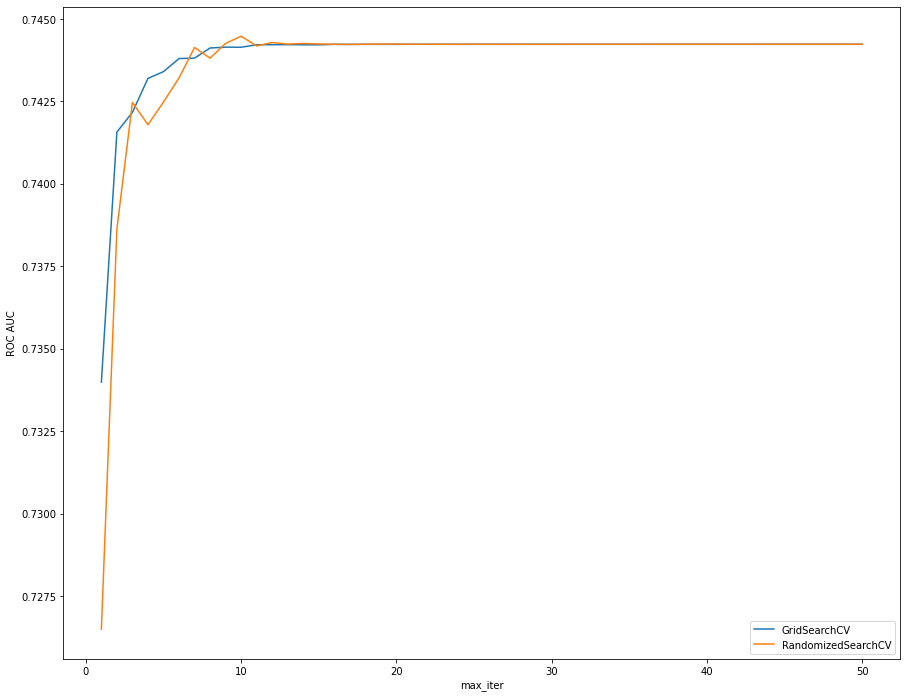

In [169]:
# Визуализация результатов
result_gscv = pd.Series(model_test_gscv, index = [x for x in range(1, 51, 1)])
print('Лучший результат модели по GridSearchCV (ROC_AUC = {}) при параметре = {}'.format(result_gscv.max(), result_gscv[result_gscv == result_gscv.max()].index))
print()
result_rscv = pd.Series(model_test_rscv, index = [x for x in range(1, 51, 1)])
print('Лучший результат модели по RandomizedSearchCV (ROC_AUC = {}) при параметре = {}'.format(result_rscv.max(), result_rscv[result_rscv == result_rscv.max()].index))
print()

plt.figure(figsize=(15, 12))
ax = sns.lineplot(x=range(1, 51, 1), y=result_gscv, label='GridSearchCV')
ax = sns.lineplot(x=range(1, 51, 1), y=result_rscv, label='RandomizedSearchCV')
ax.set(ylabel='ROC AUC', xlabel='max_iter')
plt.legend(loc='lower right')
plt.show()

Модель, выбранная при помощи RandomizedSearchCV, более нестабильна при малом кол-ве итераций. Обе модели выходят на устойчивое плато в районе 20.

## Итог

### Модель, выбранная при помощи GridSearchCV

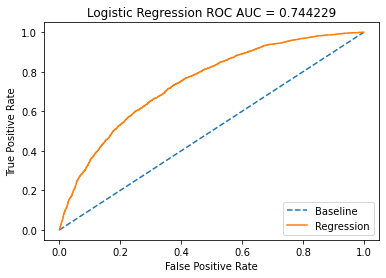

In [170]:
# Рассчет и визуализация ROC AUC
probs = best_model_gscv.best_estimator_.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Accuracy: 		 0.6719512195121952
Precision: 		 0.2254598433800765
Recall: 		 0.6776135741652983
F1 score: 		 0.338343809784094
Confusion matrix:


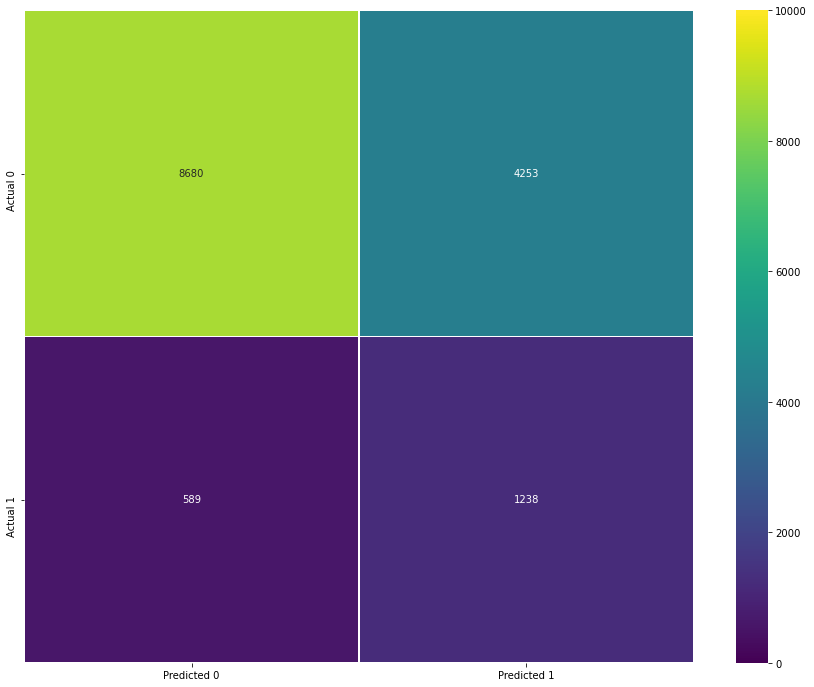

In [171]:
# Дополнительные метрики
predictions = best_model_gscv.best_estimator_.predict(X_test)
print('Accuracy: \t\t', accuracy_score(y_test, predictions))
print('Precision: \t\t', precision_score(y_test, predictions))
print('Recall: \t\t', recall_score(y_test, predictions))
print('F1 score: \t\t', f1_score(y_test, predictions))

print('Confusion matrix:')
plt.figure(figsize=(15, 12))
matrix = pd.DataFrame(confusion_matrix(y_test, predictions), 
                      columns=[f"Predicted {i}" for i in range(0, 2)], 
                      index = [f"Actual {i}" for i in range(0, 2)])
sns.heatmap(matrix, vmin=0, vmax=10000, annot=True, linewidths=.5, cmap='viridis', fmt='d')
plt.show()

### Модель, выбранная при помощи RandomizedSearchCV

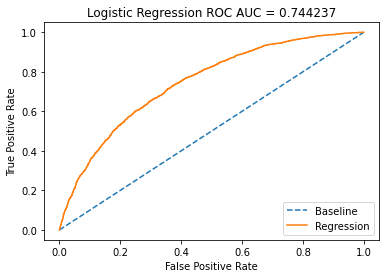

In [172]:
# Рассчет и визуализация ROC AUC
probs = best_model_rscv.best_estimator_.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Accuracy: 		 0.672289972899729
Precision: 		 0.22566532993073277
Recall: 		 0.6776135741652983
F1 score: 		 0.33857514016135654
Confusion matrix:


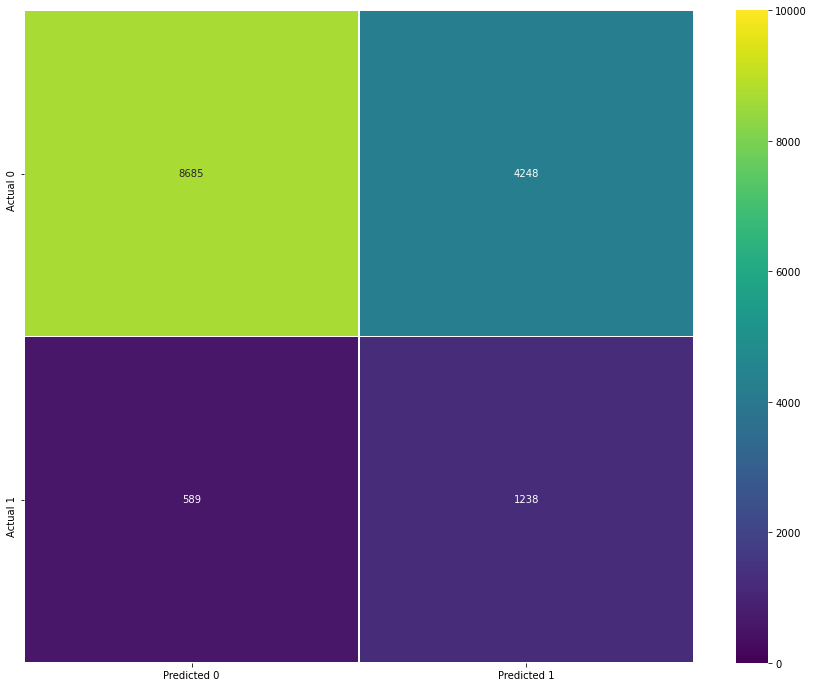

In [173]:
# Дополнительные метрики
predictions = best_model_rscv.best_estimator_.predict(X_test)
print('Accuracy: \t\t', accuracy_score(y_test, predictions))
print('Precision: \t\t', precision_score(y_test, predictions))
print('Recall: \t\t', recall_score(y_test, predictions))
print('F1 score: \t\t', f1_score(y_test, predictions))

print('Confusion matrix:')
plt.figure(figsize=(15, 12))
matrix = pd.DataFrame(confusion_matrix(y_test, predictions), 
                      columns=[f"Predicted {i}" for i in range(0, 2)], 
                      index = [f"Actual {i}" for i in range(0, 2)])
sns.heatmap(matrix, vmin=0, vmax=10000, annot=True, linewidths=.5, cmap='viridis', fmt='d')
plt.show()

Подбор гиперпараметров существенно не улучшил модель. На тестовой выборке, модель, выбранная при помощи RandomizedSearchCV, немного лучше предсказывает недефолтных клиентов. Для валидации, на скрытой выборке на Kaggle, будет использована:
- LogisticRegression(C=10, class_weight={0: 0.5, 1: 0.5}, max_iter=20, random_state=100, solver='sag', warm_start=True) со сбалансированной выборкой

# Submission

## Data preprocessing

In [174]:
# Функция возвращает данные после предобработки
def preprocessing(df):
    
    # Удаление 'client_id'
    df.drop('client_id', axis = 1, inplace = True)
    
    # Перевод 'app_date' в формат datetime
    df.app_date = pd.to_datetime(df.app_date, infer_datetime_format=True)
    
    # Кодировка бинарных признаков
    for column in obj_cols(df, bin_cols):
        df[column] = label_encoder.fit_transform(df[column])
    
    # Кодировка 'education'
    mapping_dict = {'SCH': 1, 'UGR': 2, 'GRD':3, 'PGR':4, 'ACD':5}
    df['education'] = df.education.map(mapping_dict)
    
    # Нормализация признаков
    for col in ['decline_app_cnt', 'bki_request_cnt']:
        df[col] = df[col].apply(lambda x: x+1)
    for col in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
        df[col] = stats.boxcox(df[col])[0]
    
    # Изменение размерности 'region_rating'
    df['region_rating'] = df['region_rating']/100
    
    # Перевод 'decline_app_cnt' в категориальный признак
    df['decline_app_cnt'] = df.decline_app_cnt.apply(lambda x: 1 if x>0 else 0)
    
    # Создание 'app_month' и 'timestamp', удаление 'app_date'
    df['app_month'] = df.app_date.dt.month
    df['timestamp'] = df.app_date.values.astype(np.int64) // 10 ** 9
    df.drop('app_date', axis = 1, inplace = True)
    
    
    # Локальная функция для заполнения пропусков в 'education'
    def edu_fill_na(row):
        if row['edu_isna'] == 1:
            return edu_predictions[row.name]
        else:
            return row['education']
    
    # Заполнение пропусков 'education'
    edu_na_s = df[df.education.isna() == True].drop('education', axis = 1)
    edu_na_cat = edu_OHE.transform(edu_na_s[edu_cat_cols].values)
    edu_na_num = edu_SS.transform(edu_na_s[edu_num_cols].values)
    edu_na = np.hstack([edu_na_num, edu_na_s[edu_bin_cols].values, edu_na_cat])
    edu_pred = edu_model.predict(edu_na)
    edu_pred = pd.Series(edu_model.predict(edu_na), index = edu_na_s.index)
    df['edu_isna'] = df.education.apply(isna)
    df['education'] = df.apply(lambda x: edu_pred[x.name] if x['edu_isna'] == 1 else x['education'], axis = 1)
    
    # Кластеризация
    df['cluster'] = kmeans.predict(df[cluster_cols])
    
    # Итог PCA
    df['bki_ovrl'] = (df.score_bki - df.score_bki.min())*df.bki_request_cnt.values
    df.drop('bki_request_cnt', axis = 1, inplace = True)
    
    # Переменные на основе логики
    df['reliable_cust'] = df.first_time - df.sna
    df['travel_time'] = df.home_address - df.work_address
    df['travel_time'] = df.travel_time.apply(lambda x: -x if x<0 else x)
    df['income_to_expenses'] = df.income/(1+df.car+df.car_type+df.foreign_passport)
    
    # Агрегированные переменные
    df['bin_cat_rating'] = df[['car', 'car_type', 'good_work', 'foreign_passport',
                                 'education', 'first_time', 'app_month']].sum(axis=1) - df[['sex', 'decline_app_cnt', 
                                                                                               'work_address', 'sna']].sum(axis=1)
    df['bin_cat_rating'] = df['bin_cat_rating'] + 7
    df['num_category'] = df.apply(num_transform, axis = 1)
    
    return df

In [175]:
# Загрузка данных
test = pd.read_csv('test.csv')

In [176]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [177]:
for column in test.columns:
    value = test[column].isna().sum()
    if value > 0:
        print(column.upper())
        print('%% пропущенных данных в столбце: \t{}'.format(value/len(train[column])*100))
        print('(%% от общего кол-ва данных: \t{})'.format(value/np.product(train.shape)*100))
        print()

EDUCATION
%% пропущенных данных в столбце: 	0.2317104567812572
(%% от общего кол-ва данных: 	0.00891194064543297)



In [178]:
client_id = test.client_id

In [179]:
# Создание 'default' в тестовых данных
test['default'] = 100

In [180]:
# Предобработка и результат
valid= preprocessing(test)
valid.sample(5)

education  sex       age  car  car_type  decline_app_cnt  good_work  \
18334        1.0    1  3.142932    1         0                0          0   
5143         1.0    0  3.230527    0         0                0          1   
11815        1.0    1  2.897590    0         0                1          0   
19659        3.0    0  2.949251    0         0                0          0   
4001         1.0    0  3.179358    0         0                1          0   

       score_bki  region_rating  home_address  ...  app_month   timestamp  \
18334  -1.420570            0.6             1  ...          2  1392854400   
5143   -2.613886            0.7             1  ...          2  1391904000   
11815  -1.678407            0.8             2  ...          3  1395014400   
19659  -1.686008            0.7             2  ...          1  1388880000   
4001   -1.500075            0.4             2  ...          2  1392768000   

       edu_isna  cluster  bki_ovrl  reliable_cust  travel_time  \
18334         0        2  0.000000             -1            1   
5143          0        4  1.532980              2            0   
11815         0        3  1.939295              3            1   
19659         0        1  1.250921              3            1   
4001          0        3  3.310996              2            1   

       income_to_expenses  bin_cat_rating  num_category  
18334            2.999516             7.0             2  
5143             5.698778            12.0             4  
11815            2.946478            10.0             2  
19659            5.924322            11.0             2  
4001             5.613149             8.0             0  

[5 rows x 26 columns]

In [181]:
# Проверка, что данные содержат одинаковое кол-во признаков
print(len(train.columns)-len(test.columns))

0


## Предобработка для моделирования

In [182]:
# Обработка признаков для модели
X_valid_cat = main_OHE.transform(valid[cat_cols].values)
X_valid_num = main_SS.transform(valid[num_cols].values)
X_valid = np.hstack([X_valid_num, valid[bin_cols].values, X_valid_cat])

## Применение модели

In [183]:
predictions = best_model_rscv.best_estimator_.predict(X_valid)

probs = model.predict_proba(X_valid)
probs = probs[:, 1]

In [184]:
result = pd.DataFrame({'client_id': client_id, 'default': probs})

In [185]:
result

client_id   default
0          74835  0.202997
1          17527  0.769680
2          75683  0.319792
3          26883  0.416635
4          28862  0.169487
...          ...       ...
36344      83775  0.800986
36345     106254  0.094146
36346      81852  0.794448
36347       1971  0.709919
36348      69044  0.727245

[36349 rows x 2 columns]

In [186]:
result.to_csv('submission.csv', index = False)

# Результат

На валидационной выборке (Kaggle), ROC AUC = 0.73965.